In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,  Dropout, Input, LSTM, Embedding,SpatialDropout1D, BatchNormalization, Flatten, LayerNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow_text as text
import tensorflow_hub as hub

import pandas_tfrecords as pdtfr

import matplotlib.pyplot as plt
import re

from pathlib import Path

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet


import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import keras_tuner as kt
import seaborn as sns
import tensorflow_datasets as tfds


tf.random.set_seed(0)
np.random.seed(0)
stop_words_list = stopwords.words('english') 

tf.config.run_functions_eagerly(False)
#import tensorflow_data_validation as tfdv
#tf.debugging.set_log_device_placement(True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split
from transformers import  RobertaTokenizer, TFRobertaModel
import copy


2024-10-07 10:38:05.898094: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-07 10:38:05.920577: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 10:38:05.920612: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 10:38:05.921366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 10:38:05.925547: I tensorflow/core/platform/cpu_feature_guar

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10966679201565800011
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22287220736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10863641284339433268
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


[nltk_data] Downloading package stopwords to /home/n/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/n/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/n/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/n/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /home/n/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
2024-10-07 10:38:08.023355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L

Num GPUs Available:  1


# Set Parameters

In [2]:
batch_size=256

ETL_STOPWORDS= False
TRAIN_MODE= False
RETRAIN_MODE = True

TUNNING = False
INFERENCE_MODE = True

threshold = 1
classN=1
min_freq = 5


DATA_CHECKPOINTS_DIR = './checkpoints'
tfrecord_filename = "train_tmp.tfrecord"
train_tmp_record_path = f'{DATA_CHECKPOINTS_DIR}/{tfrecord_filename}'

!mkdir -p {DATA_CHECKPOINTS_DIR}

# Read dataset


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, 
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset

2024-10-07 10:38:08.592848: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 10:38:08.594569: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-07 10:38:08.596261: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

<_PrefetchDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [4]:
for i, o in train_dataset.take(5):
    print(i, o)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on t

2024-10-07 10:38:08.910874: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:

def clean_reviews(review):
    
    lowercase = tf.strings.lower(review)


    special_chars_pattern = r"[^a-zA-Z0-9\'\s]"
    lowercase = tf.strings.regex_replace(lowercase, special_chars_pattern, ' ')

    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    
    return stripped_html

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

MAPPING_DICT = {
    "*" : "one star ",
    "**" : "two star ",
    "***" : "three star ",
    "****" : "four star ",
    "*****" : "five star ",
    "1" : " one",
    "2" : " two",
    "3" : " three",
    "4" : " four",
    "5" : " five",
    "6" : " six",
    "7" : " seven",
    "8" : " eight",
    "9" : " nine",
    "0" : " zero",
    "10" : " ten ",
    "n't": " not"
}

def convert_tfdataframe_to_pddataframe(tf_df):
    data_list = []
    for i, (features, label) in enumerate(tf_df):
        
        if i % 5000 == 0 : print(f"{i}/{len(tf_df)}")
        
        cleaned_features = clean_reviews(features)
        cleaned_features = cleaned_features.numpy().decode('utf-8')

        # #Lematization to reduce the number of words 
        # As we will be using LLM to get embeddings for the sentences, if we apply lemmatization it is possible that it will lose context and provide a not so good embedding.
        # For this reason, the implementation will be commented
        
        # pos_tags = pos_tag(word_tokenize(cleaned_features))

        # lemmatized_sentence = []

        # for word, tag in pos_tags:
        #     wordnet_pos = get_wordnet_pos(tag) or wordnet.NOUN  # Default to noun if no mapping is found
        #     lemmatized_word = lemmatizer.lemmatize(word, wordnet_pos)
        #     lemmatized_sentence.append(lemmatized_word)
            
        # cleaned_features = ' '.join(lemmatized_sentence)

        # Applying mapping in important details for sentiment models
        for key, value in MAPPING_DICT.items():
            cleaned_features = cleaned_features.replace(key, value)

        data_list.append((features.numpy().decode('utf-8'), cleaned_features, label.numpy()))

    # Create a Pandas DataFrame
    return pd.DataFrame(data_list, columns = [ "raw_review", "review", "sentiment"])

if ETL_STOPWORDS:
    # Create a Pandas DataFrame
    train_dataset = convert_tfdataframe_to_pddataframe(train_dataset)
    train_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/train_dataset.pkl")  
else:
    train_dataset = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/train_dataset.pkl")
    
train_dataset

raw_review  \
0      This was an absolutely terrible movie. Don't b...   
1      I have been known to fall asleep during films,...   
2      Mann photographs the Alberta Rocky Mountains i...   
3      This is the kind of film for a snowy Sunday af...   
4      As others have mentioned, all the women that g...   
...                                                  ...   
24995  I have a severe problem with this show, severa...   
24996  The year is 1964. Ernesto "Che" Guevara, havin...   
24997  Okay. So I just got back. Before I start my re...   
24998  When I saw this trailer on TV I was surprised....   
24999  First of all, Riget is wonderful. Good comedy ...   

                                                  review  sentiment  
0      this was an absolutely terrible movie  do not ...          0  
1      i have been known to fall asleep during films ...          0  
2      mann photographs the alberta rocky mountains i...          0  
3      this is the kind of film for a snowy sunday af...          1  
4      as others have mentioned  all the women that g...          1  
...                                                  ...        ...  
24995  i have a severe problem with this show  severa...          0  
24996  the year is  one nine six four  ernesto  che  ...          1  
24997  okay  so i just got back  before i start my re...          0  
24998  when i saw this trailer on tv i was surprised ...          0  
24999  first of all  riget is wonderful  good comedy ...          1  

[25000 rows x 3 columns]

In [6]:
if ETL_STOPWORDS:
    # Create a Pandas DataFrame
    test_dataset = convert_tfdataframe_to_pddataframe(test_dataset)
    test_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/test_dataset.pkl")  
else:
    test_dataset = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/test_dataset.pkl")

# Check statistics

Check dtypes

In [7]:
train_dataset.dtypes

raw_review    object
review        object
sentiment      int64
dtype: object

In [8]:
test_dataset.dtypes

raw_review    object
review        object
sentiment      int64
dtype: object

Check duplicated

In [9]:
train_dataset.review.duplicated().sum()

96

In [10]:
train_dataset[train_dataset.review.duplicated()]

raw_review  \
547    I like Chris Rock, but I feel he is wasted in ...   
2161   God, I was bored out of my head as I watched t...   
3311   Is there any other time period that has been s...   
3554   I saw this in the summer of 1990. I'm still an...   
3800   Somehow they summed up the 60's, ten years tha...   
...                                                  ...   
24202  This movie had a IMDB rating of 8.1 so I expec...   
24380  <br /><br />Back in his youth, the old man had...   
24434  The 60s (1999) D: Mark Piznarski. Josh Hamilto...   
24540  How has this piece of crap stayed on TV this l...   
24587  This insipid mini operetta featuring a Eddy-Mc...   

                                                  review  sentiment  
547    i like chris rock  but i feel he is wasted in ...          0  
2161   god  i was bored out of my head as i watched t...          0  
3311   is there any other time period that has been s...          0  
3554   i saw this in the summer of  one nine nine zer...          0  
3800   somehow they summed up the  six zero's  ten ye...          0  
...                                                  ...        ...  
24202  this movie had a imdb rating of  eight  one so...          0  
24380   br    br   back in his youth  the old man had...          0  
24434  the  six zeros   one nine nine nine  d  mark p...          0  
24540  how has this piece of crap stayed on tv this l...          0  
24587  this insipid mini operetta featuring a eddy mc...          0  

[96 rows x 3 columns]

In [11]:
test_dataset.review.duplicated().sum()

199

In [12]:
train_dataset.drop_duplicates(inplace=True)
test_dataset.drop_duplicates(inplace=True)
train_dataset.review.duplicated().sum(), test_dataset[test_dataset.review.duplicated()]

(0,
 Empty DataFrame
 Columns: [raw_review, review, sentiment]
 Index: [])

In [13]:
train_dataset.shape, test_dataset.shape

((24904, 3), (24801, 3))

Check common reviews in both datasets

In [14]:
train_reviews = train_dataset.review.unique().tolist()
test_dataset[test_dataset.review.isin(train_reviews)]

raw_review  \
237    Bathebo, you big dope.<br /><br />This is the ...   
265    Im a huge M Lillard fan that's why I ended up ...   
673    I have been a huge Lynn Peterson fan ever sinc...   
696    Contains spoilers. <br /><br />The British dir...   
1018   Just about everything in this movie is wrong, ...   
...                                                  ...   
24004  From director Barbet Schroder (Reversal of For...   
24012  This movie really shows its age. The print I s...   
24032  This movie purports to be a character study of...   
24528  There are many different versions of this one ...   
24742  Audrey, I know you truly cherish your husband ...   

                                                  review  sentiment  
237    bathebo  you big dope  br    br   this is the ...          0  
265    im a huge m lillard fan that's why i ended up ...          1  
673    i have been a huge lynn peterson fan ever sinc...          0  
696    contains spoilers   br    br   the british dir...          0  
1018   just about everything in this movie is wrong  ...          0  
...                                                  ...        ...  
24004  from director barbet schroder  reversal of for...          0  
24012  this movie really shows its age  the print i s...          0  
24032  this movie purports to be a character study of...          0  
24528  there are many different versions of this one ...          0  
24742  audrey  i know you truly cherish your husband ...          0  

[123 rows x 3 columns]

In [15]:
train_dataset[train_dataset.review == test_dataset[test_dataset.review.isin(train_reviews)].review.tolist()[0]]

raw_review  \
6602  Bathebo, you big dope.<br /><br />This is the ...   

                                                 review  sentiment  
6602  bathebo  you big dope  br    br   this is the ...          0

In [16]:
test_dataset[test_dataset.review == test_dataset[test_dataset.review.isin(train_reviews)].review.tolist()[0]]

raw_review  \
237  Bathebo, you big dope.<br /><br />This is the ...   

                                                review  sentiment  
237  bathebo  you big dope  br    br   this is the ...          0

Let's remove it from one of the datasets - Which one to remove ? We need to understand first the distribution and where it makes more sense to be kept

In [17]:
#Check for the duplicated sentence's words and their frequencies in both dataset. 
common_reviews_list = test_dataset[test_dataset.review.isin(train_reviews)].review.tolist()
common_reviews_list

["bathebo  you big dope  br    br   this is the worst piece of crap i've seen in a long time  i have just stumbled onto it on late night tv and it is painful to watch  really painful  how does something like this get made   horrible  horrible  horrible  oooooo       the toilet is flushing by itself again  scary toilet  scary toilet  scary toilet   one nine nine two does not seem like that long ago to me  but watching this makes it seem like  one nine five two  i mean its horrible  please do not waste your time on the drivel  br    br   scary old black man telling them not to build the pool in the yard  scary  scary  how does this stuff get made   ",
 "im a huge m lillard fan that's why i ended up watching this movie  honestly i doubt that if he was not in the movie i would of enjoyed it as much or even watched it but once i did watch it realize the story was pretty decent  a bad ending i must say but i did see it coming  it's a low budget movie and some of the actors were not really go

In [18]:
test_dataset = test_dataset[~test_dataset.review.isin(train_reviews)]

## Word frequency analysis

In [19]:
def check_word_frequency(train_df):
    
    print("Dataset lentgh : ",len(train_df))

    tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;=?@[\\]^_´`«»{|}~\t\n',oov_token='<oov>')
    tokenizer.fit_on_texts(train_df.review.values.tolist())

    word_frequency = {}
    for i, (word, count) in enumerate(tokenizer.word_counts.items()):
        word_frequency[word]=count
            
    return word_frequency

def update_stop_words(word_frequency, freq,max_freq,stop_word):
 
    it = 0
    for word, count in word_frequency.items():
        if count < freq:
            if it < 10:
                print(word)
                it +=1
            stop_word.append(word)
        elif count >max_freq :
            stop_word.append(word)
            
    return list(set(stop_word))


word_frequency= check_word_frequency(train_dataset)
test_word_frequency= check_word_frequency(test_dataset)

word_frequency

Dataset lentgh :  24904
Dataset lentgh :  24678


{'this': 75719,
 'was': 50361,
 'an': 21482,
 'absolutely': 1477,
 'terrible': 1632,
 'movie': 43434,
 'do': 17542,
 'not': 63888,
 'be': 26876,
 'lured': 28,
 'in': 93687,
 'by': 22502,
 'christopher': 410,
 'walken': 124,
 'or': 17944,
 'michael': 1296,
 'ironside': 26,
 'both': 3398,
 'are': 30247,
 'great': 9025,
 'actors': 4400,
 'but': 42480,
 'must': 3195,
 'simply': 1963,
 'their': 11345,
 'worst': 2717,
 'role': 3173,
 'history': 1319,
 'even': 12617,
 'acting': 6458,
 'could': 9204,
 'redeem': 69,
 "movie's": 422,
 'ridiculous': 960,
 'storyline': 800,
 'is': 110200,
 'early': 1592,
 'nineties': 41,
 'us': 3776,
 'propaganda': 203,
 'piece': 1529,
 'the': 335235,
 'most': 8768,
 'pathetic': 465,
 'scenes': 5199,
 'were': 11235,
 'those': 4687,
 'when': 14134,
 'columbian': 4,
 'rebels': 47,
 'making': 2943,
 'cases': 163,
 'for': 44212,
 'revolutions': 10,
 'maria': 165,
 'conchita': 9,
 'alonso': 11,
 'appeared': 370,
 'phony': 81,
 'and': 163710,
 'her': 18348,
 'pseudo': 1

In [20]:
most_frequent_words ={x : word_frequency[x] for x in word_frequency.keys() if word_frequency[x] > 10000}
most_frequent_words = dict(sorted(most_frequent_words.items(), key=lambda item: item[1],  reverse=True))

most_frequent_words, len(most_frequent_words)

({'the': 335235,
  'and': 163710,
  'a': 162666,
  'of': 145418,
  'to': 135349,
  'is': 110200,
  'br': 101610,
  'in': 93687,
  'it': 78891,
  'i': 76954,
  'this': 75719,
  'that': 69626,
  'not': 63888,
  'was': 50361,
  'as': 46800,
  'one': 44340,
  'for': 44212,
  'with': 43999,
  'movie': 43434,
  'but': 42480,
  'film': 39006,
  'on': 34098,
  'are': 30247,
  'you': 29791,
  'his': 29311,
  'have': 28454,
  'he': 26894,
  'be': 26876,
  'all': 23903,
  'at': 23456,
  'by': 22502,
  'an': 21482,
  'they': 21074,
  'who': 20558,
  'so': 20522,
  'from': 20421,
  'like': 20218,
  'her': 18348,
  'or': 17944,
  'just': 17702,
  'do': 17542,
  'about': 17325,
  'has': 17113,
  "it's": 17101,
  'out': 17049,
  'if': 16734,
  'there': 15719,
  'some': 15706,
  'what': 15318,
  'good': 15062,
  'zero': 14811,
  'two': 14575,
  'more': 14204,
  'when': 14134,
  'very': 14031,
  'would': 13252,
  'up': 13235,
  'no': 12650,
  'time': 12626,
  'she': 12620,
  'even': 12617,
  'my': 12449

Check different word distribution 

In [21]:
word_frequency_df = pd.DataFrame({x : [word_frequency[x]] for x in word_frequency.keys()}).T.reset_index().rename(columns = {"index":"word", 0:"frequency"})
test_word_frenquecy_df = pd.DataFrame(pd.DataFrame.from_dict({x : [test_word_frequency[x]] for x in test_word_frequency.keys()})).T.reset_index().rename(columns = {"index":"word", 0:"test_frequency"})
display(test_word_frenquecy_df)

word_frequency_df = pd.merge(word_frequency_df, test_word_frenquecy_df, on='word', how='outer')
word_frequency_df

word  test_frequency
0                there           15396
1                  are           29399
2                films            6767
3                 that           66397
4                 make            7770
...                ...             ...
84471           walkup               1
84472              elr               2
84473     initializing               1
84474  regurgitation's               1
84475       hallowe'en               1

[84476 rows x 2 columns]

word  frequency  \
0                                                  '     1474.0   
1                                                 ''       13.0   
2                                                ''a        1.0   
3                                            ''after        1.0   
4                                            ''alvin        NaN   
...                                              ...        ...   
119671                                 zzzzzzzzzzzzz        1.0   
119672                            zzzzzzzzzzzzzzzzzz        NaN   
119673               zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz        1.0   
119674     zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz        1.0   
119675  zzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzz        1.0   

        test_frequency  
0               1269.0  
1                  8.0  
2                  1.0  
3                  NaN  
4                  1.0  
...                ...  
119671             1.0  
119672             1.0  
119673             NaN  
119674             NaN  
119675             NaN  

[119676 rows x 3 columns]

In [22]:
word_frequency_df.isna().sum()


word                  0
frequency         33784
test_frequency    35200
dtype: int64

In [23]:
word_frequency_df[(word_frequency_df.frequency.isna()) & (~word_frequency_df.test_frequency.isna())].describe()

frequency  test_frequency
count        0.0    33784.000000
mean         NaN        1.799668
std          NaN        2.636983
min          NaN        1.000000
25%          NaN        1.000000
50%          NaN        1.000000
75%          NaN        2.000000
max          NaN      133.000000

In [24]:
word_frequency_df[(word_frequency_df.frequency.isna()) & (~word_frequency_df.test_frequency.isna()) & (word_frequency_df.test_frequency>5)].sort_values(by='test_frequency', ascending=False)

word  frequency  test_frequency
83105       ponyo        NaN           133.0
23518  chupacabra        NaN            74.0
85200        prue        NaN            60.0
90844      rockne        NaN            57.0
59993      kersey        NaN            51.0
...           ...        ...             ...
51366        hern        NaN             6.0
97194    silencio        NaN             6.0
97170         sik        NaN             6.0
51794   hillsboro        NaN             6.0
486         'beep        NaN             6.0

[1331 rows x 3 columns]

In [25]:
word_frequency_df[(~word_frequency_df.frequency.isna()) & (word_frequency_df.test_frequency.isna()) & (word_frequency_df.frequency>5)].sort_values(by='test_frequency', ascending=False)

word  frequency  test_frequency
744            'but        6.0             NaN
1261          'cut'        6.0             NaN
1440    'dillinger'        7.0             NaN
1612        'earth'        7.0             NaN
2012     'forbidden        8.0             NaN
...             ...        ...             ...
119570        zorak        8.0             NaN
119582      zorro's        6.0             NaN
119593           zp       11.0             NaN
119610    zuckerman        6.0             NaN
119633       zuniga       17.0             NaN

[1438 rows x 3 columns]

There will be 1205 words in test dataset that will not appear in training set. The problem could be related with this one

In [26]:
test_missing_words  = word_frequency_df[(word_frequency_df.frequency.isna()) & (~word_frequency_df.test_frequency.isna()) & (word_frequency_df.test_frequency>5)].sort_values(by='test_frequency', ascending=False)
test_missing_words[test_missing_words.test_frequency>10].head(60)

word  frequency  test_frequency
83105        ponyo        NaN           133.0
23518   chupacabra        NaN            74.0
85200         prue        NaN            60.0
90844       rockne        NaN            57.0
59993       kersey        NaN            51.0
99638       sosuke        NaN            51.0
42292   flatliners        NaN            47.0
50211       haruhi        NaN            45.0
39027         evie        NaN            45.0
48269        grint        NaN            44.0
57345       jackal        NaN            44.0
75046   nightbreed        NaN            43.0
92660     sampedro        NaN            42.0
65644      lumumba        NaN            41.0
70677    minghella        NaN            40.0
39417     existenz        NaN            40.0
53813       hynkel        NaN            40.0
29743       danton        NaN            40.0
23883          cky        NaN            37.0
50714        hearn        NaN            37.0
11026   aschenbach        NaN            37.0
104736      tadzio        NaN            36.0
76409       obelix        NaN            36.0
22213       changi        NaN            35.0
9991          apna        NaN            35.0
112827     uzumaki        NaN            35.0
53985       icarly        NaN            35.0
55763        inman        NaN            33.0
92687      samuels        NaN            33.0
83269        porgy        NaN            33.0
104336       swope        NaN            33.0
44354     fujimori        NaN            32.0
74167      nazarin        NaN            32.0
61661        kuzco        NaN            32.0
58530       joline        NaN            32.0
85802       putney        NaN            31.0
63307     leland's        NaN            31.0
115499     watkins        NaN            31.0
66515       mahmut        NaN            31.0
12121          avp        NaN            31.0
67474      margera        NaN            31.0
76310     o'malley        NaN            30.0
15813          bix        NaN            30.0
72525     motorama        NaN            30.0
86527         radu        NaN            30.0
34922       drebin        NaN            30.0
69752    merkerson        NaN            30.0
27572    courtenay        NaN            30.0
83343       portia        NaN            30.0
28479    crowhurst        NaN            30.0
9198     andersson        NaN            29.0
61424        kronk        NaN            29.0
90585          rix        NaN            28.0
22155    champlain        NaN            28.0
88907       renfro        NaN            28.0
91146      romulan        NaN            28.0
107342      tilney        NaN            28.0
118900       yusuf        NaN            28.0
53721         hutz        NaN            27.0
8408        almasy        NaN            27.0

In [27]:
max_freq = np.max(list(word_frequency.values())) +1 
# Update stop words list with the less frequent 

updated_stop_word = update_stop_words(word_frequency, min_freq, max_freq, stop_words_list.copy()) 

updated_stop_word

columbian
sette
accord
alberta
gunfighters
paddle
lies'
barometers
microscopically
gradations


["announcers'",
 'jacobite',
 'nipar',
 "alistair's",
 'gainsbrough',
 'neuromuscular',
 'plights',
 'harangue',
 'bullhorns',
 "violence'",
 'abcd',
 'tojo',
 'wtaf',
 'pail',
 'wof',
 'beasley',
 'lmao',
 'flesheating',
 'enoy',
 "'careful",
 'housekeepers',
 'sanitary',
 'geddit',
 "garner's",
 'baras',
 'taryn',
 'orchard',
 'meteors',
 'wildman',
 'tenebra',
 'legiunea',
 'stoopid',
 'squirrelly',
 "stage'",
 "etzel's",
 "sergeant's",
 'dusted',
 'assesment',
 'moragn',
 'implores',
 'gramme',
 'prised',
 'gegen',
 'martins',
 'plopped',
 'waldis',
 'demian',
 'ferengi',
 'ostrich',
 'sansabelt',
 'mikaele',
 'suitcases',
 'macrabe',
 'maitresse',
 'dacascos',
 'rosina',
 'courteney',
 'nativity',
 'personify',
 'dandylion',
 'toughen',
 'ticker',
 'davonne',
 'bespoiled',
 "'assa'",
 'obnoxiousness',
 'derita',
 'banshee',
 'homegirls',
 'nahhh',
 'elaborating',
 'creepazoid',
 'grabovsky',
 'dodgers',
 'nauvoo',
 'kamm',
 'filmhistory',
 "oshin's",
 'celi',
 'progressives',
 'bi

In [28]:
len(updated_stop_word)/len(word_frequency)

0.6507590928142318

In [29]:
word_frequency_df = pd.DataFrame(word_frequency.items(), columns = ["word","frequency"])
word_frequency_df.sort_values(by=['frequency'], ascending=False)[:100]

word  frequency
41     the     335235
59     and     163710
66       a     162666
71      of     145418
93      to     135349
...    ...        ...
141    its       8109
185   then       8084
1151   way       7995
386   make       7991
132   them       7949

[100 rows x 2 columns]

In [30]:
def limit_words_tf(review, sentiment):
    # Split the string into tokens
    tokens = tf.strings.split(review)

    # Limit the number of tokens to max_words
    limited_tokens = tokens[:sequence_size]
    
    # Join the tokens back into a string
    limited_review = tf.strings.reduce_join(limited_tokens, separator=' ')
        
    return limited_review, sentiment


def save_record(dataset, record_path):

    with tf.io.TFRecordWriter(record_path) as writer:
        for index, row in dataset.iterrows():
            input_ids, attention_mask, sentiment = row["input_ids"], row["attention_mask"], row["sentiment"]
            # Serialize example
            feature = {
                'input_ids': tf.train.Feature(int64_list=tf.train.Int64List(value=input_ids)),  # List feature
                'attention_mask': tf.train.Feature(float_list=tf.train.FloatList(value=attention_mask)), # List feature
                'sentiment': tf.train.Feature(int64_list=tf.train.Int64List(value=[sentiment])) # Single value feature
            }
            example_proto = tf.train.Example(features=tf.train.Features(feature=feature)).SerializeToString()
            
            writer.write(example_proto)

def clean_stop_words(raw_review, review, sentiment):
    
    
    tokens = tf.strings.split(review)
    # Filter out words to remove
    words_to_remove_tensor = tf.constant(updated_stop_word)
    mask = tf.logical_not(tf.reduce_any(tf.equal(tokens, words_to_remove_tensor[:, tf.newaxis]), axis=0))
    
    # Filter out words to remove
    filtered_tokens = tf.boolean_mask(tokens, mask)
    
    # Join the remaining tokens back into a string
    processed_data = tf.strings.reduce_join(filtered_tokens, separator=' ')
    
    sentence_size = len(tf.strings.split(processed_data))
    raw_sentence_size = len(tf.strings.split(raw_review))

    return (raw_review, processed_data, sentiment , raw_sentence_size, sentence_size)
    
def process_stop_words(td_dataset):

    # Convert to tf.dataset
    td_dataset = tf.data.Dataset.from_tensor_slices((td_dataset['raw_review'],td_dataset['review'], td_dataset['sentiment']))

    for _,i, o in td_dataset.take(1):
        print(i.shape, o.shape)
        print("Pre processed ds : ",i, o )
   
    td_dataset = td_dataset.map(clean_stop_words, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    for ri, i, o, _, l in td_dataset.take(3):
        print("Post processed ds : ",l, o, i )
        
    data_list_element = []
    total_len = len(td_dataset)

    print(f"Starting Extraction in batches {total_len} ...")
    for i, (review, features, label, raw_size,  size) in enumerate(td_dataset.take(total_len)):
        if i % 2000 == 0 : print(f"{i}/{total_len}")
        
        data_list_element.append((review.numpy(),features.numpy(), label.numpy(), raw_size.numpy(),  size.numpy()))
    
    print("Creating dataframe....")
    return pd.DataFrame(data_list_element, columns = [ "raw_review", "review", "sentiment", "raw_size", "size"])
   

    return td_dataset

def remove_stop_words(text, stop_words):
    return ' '.join([word for word in text.split() if word not in stop_words])

if ETL_STOPWORDS:

    train_ds = process_stop_words(train_dataset)
    test_ds = process_stop_words(test_dataset)

    # train_dataset['review'] = train_dataset['review'].apply(lambda x: remove_stop_words(x, updated_stop_word))
    # test_dataset['review'] = test_dataset['review'].apply(lambda x: remove_stop_words(x, updated_stop_word))

    # train_dataset['size'] = train_dataset['review'].apply(lambda x: len(x.split()))
    # test_dataset['size'] = test_dataset['review'].apply(lambda x: len(x.split()))

    # train_dataset['raw_size'] = train_dataset['raw_review'].apply(lambda x: len(x.split()))
    # test_dataset['raw_size'] = test_dataset['raw_review'].apply(lambda x: len(x.split()))

    # train_ds = train_dataset.copy()
    # test_ds = test_dataset.copy()

    display(train_ds)
    train_ds.to_pickle(f"{DATA_CHECKPOINTS_DIR}/train_ds.pkl")  
    
    test_ds.to_pickle(f"{DATA_CHECKPOINTS_DIR}/test_ds.pkl") 
    display(test_ds) 

    with open(f'{DATA_CHECKPOINTS_DIR}/word_frequency.pkl', 'wb') as f:
        pickle.dump(word_frequency, f)

    with open(f'{DATA_CHECKPOINTS_DIR}/updated_stop_word.pkl', 'wb') as f:
        pickle.dump(updated_stop_word, f)

else:
    train_ds = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/train_ds.pkl")  
    test_ds = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/test_ds.pkl") 


    with open(f'{DATA_CHECKPOINTS_DIR}/word_frequency.pkl', 'rb') as f:
        word_frequency = pickle.load(f)
        
    with open(f'{DATA_CHECKPOINTS_DIR}/updated_stop_word.pkl', 'rb') as f:
        updated_stop_word = pickle.load(f)

In [31]:
train_ds[train_ds.raw_size > train_ds.size]

Empty DataFrame
Columns: [raw_review, review, sentiment, size, raw_size]
Index: []

In [32]:
test_ds[test_ds.raw_size > test_ds.size]

Empty DataFrame
Columns: [raw_review, review, sentiment, size, raw_size]
Index: []

# Check sentence size
 

In [33]:
train_ds["size"].describe()

count    24904.000000
mean       123.959966
std         92.985994
min          4.000000
25%         66.000000
50%         92.000000
75%        151.000000
max       1390.000000
Name: size, dtype: float64

In [34]:
train_ds[train_ds["size"] > 800].review.values[0]

"match one tag team table match bubba ray spike dudley vs eddie guerrero chris benoit bubba ray spike dudley started things tag team table match eddie guerrero chris benoit according rules match opponents go tables order get win benoit guerrero heated early taking turns hammering first spike bubba ray german benoit bubba took wind dudley brother spike tried help brother referee restrained benoit guerrero corner benoit stomping away bubba guerrero set table outside spike dashed ring top rope onto guerrero outside recovering taking care spike guerrero slipped table ring helped wolverine set tandem set double middle rope would put bubba table spike knocked table right brother came crashing guerrero benoit propped another table corner tried irish whip spike bubba dashed blocked brother bubba caught fire lifted opponents back body drops bubba slammed guerrero spike stomped wolverine top rope bubba held benoit bay spike soar shortly benoit spike match continued even spike tapped bubba came b

count    24678.000000
mean       121.737540
std         91.029923
min          3.000000
25%         66.000000
50%         91.000000
75%        148.000000
max       1176.000000
Name: size, dtype: float64

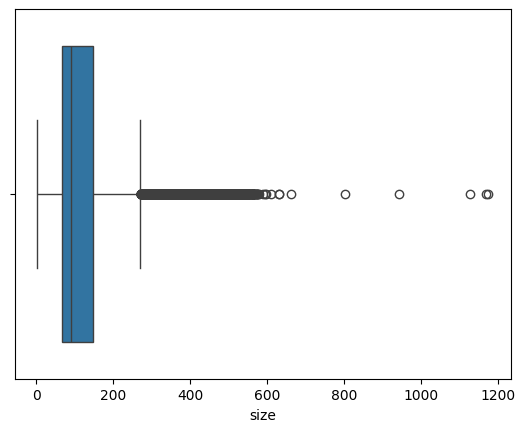

In [35]:
sns.boxplot(x=test_ds['size'])
test_ds["size"].describe()

Finding the outliers to fix the sentence size . Every sample with size considered as outlier will be trimmed

In [36]:

Q1_train = train_ds["size"].quantile(0.25)
Q3_train = train_ds["size"].quantile(0.75)
IQR_train = Q3_train - Q1_train
print("Train Q1_train : ",Q1_train)
print("Train Q3_train : ",Q3_train)
print("Train IQR : ",IQR_train)
print(f"Final training dataset size : lower limit : {(Q1_train - 1.5 * IQR_train)} | upper limit : {(Q3_train + 1.5 * IQR_train)} | total data remaining {len(train_ds[ train_ds['size'] <= (Q3_train + 1.5 * IQR_train)])}")
print("Training data to be trimed : ",len(train_ds[ train_ds["size"] > (Q3_train + 1.5 * IQR_train)]))


Train Q1_train :  66.0
Train Q3_train :  151.0
Train IQR :  85.0
Final training dataset size : lower limit : -61.5 | upper limit : 278.5 | total data remaining 23107
Training data to be trimed :  1797


In [37]:
Q1_test = test_ds["size"].quantile(0.25)
Q3_test = test_ds["size"].quantile(0.75)
IQR_test = Q3_test - Q1_test

print("Test IQR : ",IQR_test)
print(f"Final training dataset size : lower limit : {(Q1_test - 1.5 * IQR_test)} | upper limit : {(Q3_test + 1.5 * IQR_test)} | total data remaining {len(test_ds[ test_ds['size'] <= (Q3_test + 1.5 * IQR_test)])}")

print("Testing data to be trimed : ",len(test_ds[ test_ds["size"] > (Q3_test + 1.5 * IQR_test)]))


Test IQR :  82.0
Final training dataset size : lower limit : -57.0 | upper limit : 271.0 | total data remaining 22860
Testing data to be trimed :  1818


Apply the sentence cut

In [38]:
IQR_total = np.maximum((Q3_train + 1.5 * IQR_train),(Q3_test + 1.5 * IQR_test))
sequence_size = int(IQR_total)
sequence_size

278

In [39]:
test_ds = test_ds[(test_ds['size'] > 0) & (test_ds['size'] <= sequence_size)] 
train_ds = train_ds[(train_ds['size'] > 0) & (train_ds['size'] <= sequence_size)] 

In [40]:

def limit_words(review):
    # Split the string into tokens
    tokens = review.split()

    # Limit the number of tokens to max_words
    limited_tokens = tokens[:sequence_size]
    
    # Join the tokens back into a string
    limited_review = ' '.join(limited_tokens)
        
    return limited_review

# As we will be using LLM to get embeddings for the sentences, it can handle large sentences.


# print("Cleaning training dataset - sentences size processing ")
# train_ds["review"] = train_ds.review.apply(lambda x : limit_words(x)) 
# train_ds["size"] = train_ds.review.apply(lambda x : len(x.split())) 

# print("Cleaning testing dataset - sentences size processing ")
# test_ds["review"] = test_ds.review.apply(lambda x : limit_words(x)) 
# test_ds["size"] = test_ds.review.apply(lambda x : len(x.split())) 

num_labels = len(train_ds.sentiment.unique())  # number of labels for your classification task

display(train_ds)
display(test_ds)

raw_review  \
0      This was an absolutely terrible movie. Don't b...   
1      I have been known to fall asleep during films,...   
2      Mann photographs the Alberta Rocky Mountains i...   
3      This is the kind of film for a snowy Sunday af...   
4      As others have mentioned, all the women that g...   
...                                                  ...   
24994  The last Tarzan film starring Johnny Weissmull...   
24995  I have a severe problem with this show, severa...   
24996  The year is 1964. Ernesto "Che" Guevara, havin...   
24998  When I saw this trailer on TV I was surprised....   
24999  First of all, Riget is wonderful. Good comedy ...   

                                                  review  sentiment  size  \
0      absolutely terrible movie donot lured christop...          0    66   
1      known fall asleep films usually due combinatio...          0    50   
2      mann photographs rocky mountains superb fashio...          0    76   
3      kind film snowy sunday afternoon rest world go...          1    45   
4      others mentioned women go nude film mostly abs...          1    39   
...                                                  ...        ...   ...   
24994  last tarzan film starring johnny weissmuller l...          0   126   
24995  severe problem show several actually simple li...          0   272   
24996  year oneninesixfour ernesto che guevara cuban ...          1    95   
24998  saw trailer tv surprised may twozerozeroeight ...          0    76   
24999  first riget wonderful good comedy mystery thri...          1   158   

       raw_size  
0           116  
1           112  
2           132  
3            88  
4            81  
...         ...  
24994       255  
24995       518  
24996       169  
24998       169  
24999       296  

[23107 rows x 5 columns]

raw_review  \
0      There are films that make careers. For George ...   
1      A blackly comic tale of a down-trodden priest,...   
3      Poor Shirley MacLaine tries hard to lend some ...   
4      As a former Erasmus student I enjoyed this fil...   
5      My God, Ryan Gosling has made a lot of deep ch...   
...                                                  ...   
24995  Feeling Minnesota is not really a road movie, ...   
24996  This is, without doubt, one of my favourite ho...   
24997  Most predicable movie I've ever seen...extreme...   
24998  It's exactly what I expected from it. Relaxing...   
24999  They just don't make cartoons like they used t...   

                                                  review  sentiment  size  \
0      films make careers george romero night living ...          1    95   
1      comic tale trodden priest nazarin showcases ec...          1   156   
3      poor shirley maclaine tries hard lend gravitas...          0   145   
4      former student enjoyed film much realistic fun...          1    37   
5      god ryan gosling made lot deep characters care...          1    67   
...                                                  ...        ...   ...   
24995  feeling minnesota really road movie that's sti...          0    98   
24996  without doubt one favourite horror films ever ...          1   173   
24997  predicable movie i've ever seen extremely bori...          0    89   
24998  exactly expected relaxing humorous entertainin...          1    39   
24999  donot make cartoons like used one wit great ch...          1    32   

       raw_size  
0           157  
1           290  
3           269  
4            81  
5           155  
...         ...  
24995       196  
24996       305  
24997       179  
24998        74  
24999        52  

[22965 rows x 5 columns]

Before thinking on trimming, we must check if any important sentiment information will not be deleted.

# Tokenize and prepare embeddings

<Axes: xlabel='sentiment'>

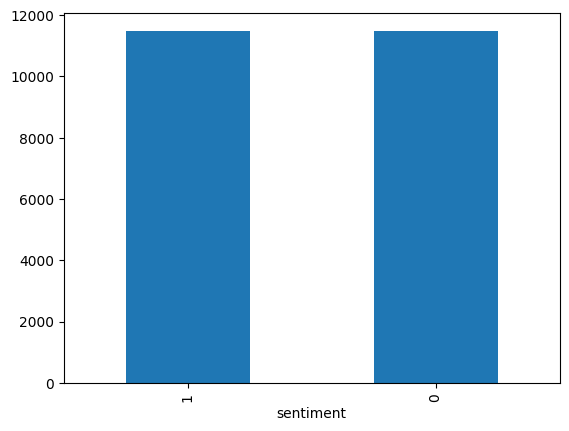

In [41]:
test_ds.sentiment.value_counts().plot.bar()


<Axes: xlabel='sentiment'>

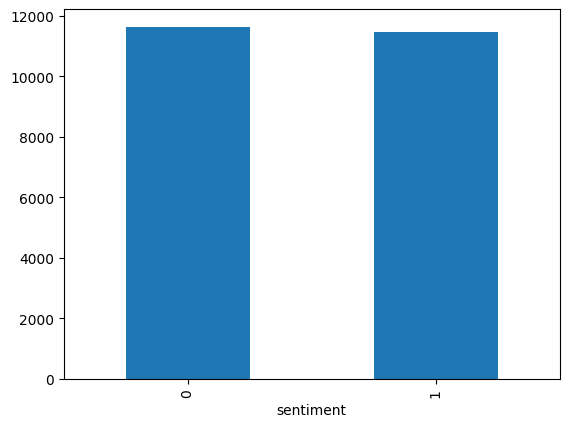

In [42]:
train_ds.sentiment.value_counts().plot.bar()


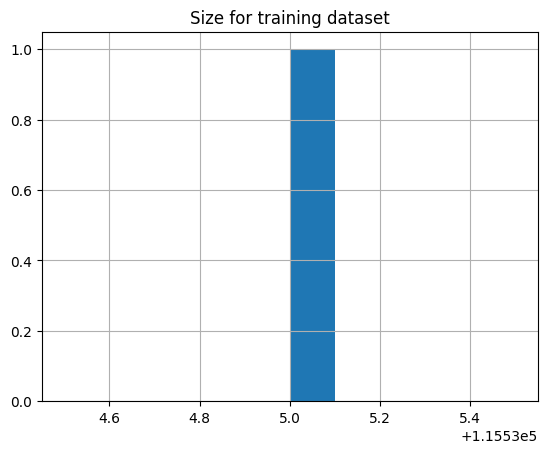

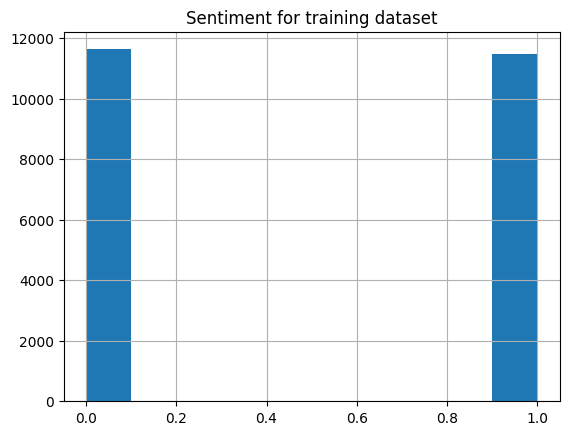

count         1.0
mean     115535.0
std           NaN
min      115535.0
25%      115535.0
50%      115535.0
75%      115535.0
max      115535.0
dtype: float64


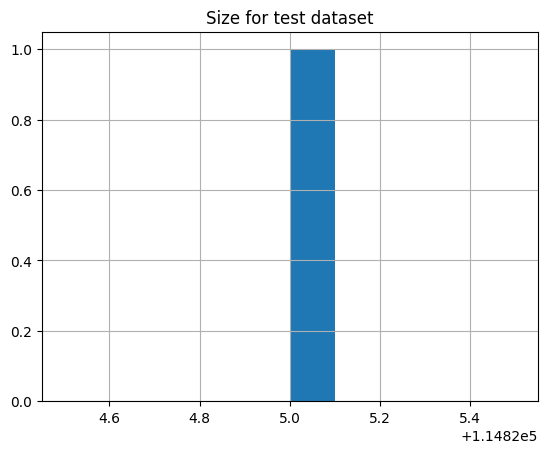

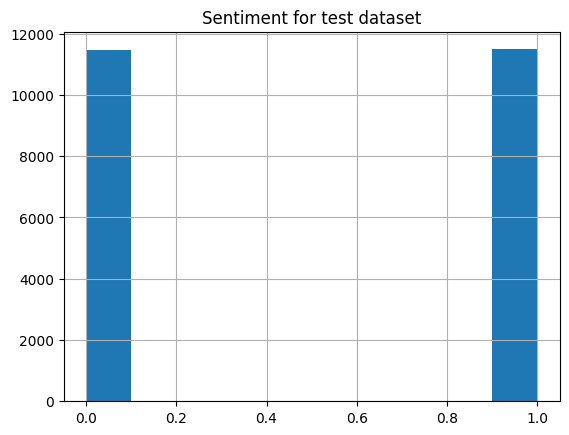

count         1.0
mean     114825.0
std           NaN
min      114825.0
25%      114825.0
50%      114825.0
75%      114825.0
max      114825.0
dtype: float64


In [43]:
plt.figure()
pd.Series(train_ds.size).hist(bins=10)
plt.title("Size for training dataset")

plt.figure()
pd.Series(train_ds.sentiment).hist()
plt.title("Sentiment for training dataset")

plt.show()
print(pd.Series(train_ds.size).describe())

plt.figure()
pd.Series(test_ds.size).hist()
plt.title("Size for test dataset")

plt.figure()
pd.Series(test_ds.sentiment).hist()
plt.title("Sentiment for test dataset")

plt.show()
print(pd.Series(test_ds.size).describe())

In [44]:
train_ds = train_ds#[["review","sentiment"]]
test_ds = test_ds#[["review","sentiment"]]
train_ds.sentiment = train_ds.sentiment.astype("int8")
test_ds.sentiment = test_ds.sentiment.astype("int8")

display(train_ds)
display(test_ds)

raw_review  \
0      This was an absolutely terrible movie. Don't b...   
1      I have been known to fall asleep during films,...   
2      Mann photographs the Alberta Rocky Mountains i...   
3      This is the kind of film for a snowy Sunday af...   
4      As others have mentioned, all the women that g...   
...                                                  ...   
24994  The last Tarzan film starring Johnny Weissmull...   
24995  I have a severe problem with this show, severa...   
24996  The year is 1964. Ernesto "Che" Guevara, havin...   
24998  When I saw this trailer on TV I was surprised....   
24999  First of all, Riget is wonderful. Good comedy ...   

                                                  review  sentiment  size  \
0      absolutely terrible movie donot lured christop...          0    66   
1      known fall asleep films usually due combinatio...          0    50   
2      mann photographs rocky mountains superb fashio...          0    76   
3      kind film snowy sunday afternoon rest world go...          1    45   
4      others mentioned women go nude film mostly abs...          1    39   
...                                                  ...        ...   ...   
24994  last tarzan film starring johnny weissmuller l...          0   126   
24995  severe problem show several actually simple li...          0   272   
24996  year oneninesixfour ernesto che guevara cuban ...          1    95   
24998  saw trailer tv surprised may twozerozeroeight ...          0    76   
24999  first riget wonderful good comedy mystery thri...          1   158   

       raw_size  
0           116  
1           112  
2           132  
3            88  
4            81  
...         ...  
24994       255  
24995       518  
24996       169  
24998       169  
24999       296  

[23107 rows x 5 columns]

raw_review  \
0      There are films that make careers. For George ...   
1      A blackly comic tale of a down-trodden priest,...   
3      Poor Shirley MacLaine tries hard to lend some ...   
4      As a former Erasmus student I enjoyed this fil...   
5      My God, Ryan Gosling has made a lot of deep ch...   
...                                                  ...   
24995  Feeling Minnesota is not really a road movie, ...   
24996  This is, without doubt, one of my favourite ho...   
24997  Most predicable movie I've ever seen...extreme...   
24998  It's exactly what I expected from it. Relaxing...   
24999  They just don't make cartoons like they used t...   

                                                  review  sentiment  size  \
0      films make careers george romero night living ...          1    95   
1      comic tale trodden priest nazarin showcases ec...          1   156   
3      poor shirley maclaine tries hard lend gravitas...          0   145   
4      former student enjoyed film much realistic fun...          1    37   
5      god ryan gosling made lot deep characters care...          1    67   
...                                                  ...        ...   ...   
24995  feeling minnesota really road movie that's sti...          0    98   
24996  without doubt one favourite horror films ever ...          1   173   
24997  predicable movie i've ever seen extremely bori...          0    89   
24998  exactly expected relaxing humorous entertainin...          1    39   
24999  donot make cartoons like used one wit great ch...          1    32   

       raw_size  
0           157  
1           290  
3           269  
4            81  
5           155  
...         ...  
24995       196  
24996       305  
24997       179  
24998        74  
24999        52  

[22965 rows x 5 columns]

In [45]:
test_ds, val_ds = train_test_split(test_ds,test_size=0.3,train_size=0.7)
display(test_ds)
display(val_ds)

raw_review  \
18865  I rented this movie for about $1.50 - the most...   
5874   So the Koreans are now knocking off American h...   
23776  I saw this movie on a fluke.I was standing on ...   
20511  As an indie filmmaker, I try to at least make ...   
7231   Spoiler Alert I worked as an extra on this Lif...   
...                                                  ...   
14233  sure this movie may have had its funny moments...   
21369  Stephanie Meyer is going to be so ticked! Now,...   
10661  The screen-play is very bad, but there are som...   
11716  Definitely worth watching.<br /><br />Ten diff...   
2934   I've always said that there's nothing to beat ...   

                                                  review  sentiment  size  \
18865  rented movie one fivezero complete waste money...          0    78   
5874   koreans knocking american horror flicks style ...          1    68   
23776  saw movie fluke standing fourtwond street wait...          1    84   
20511  indie filmmaker try least make decent film pie...          0   116   
7231   spoiler alert worked extra lifetime tv movie f...          1   131   
...                                                  ...        ...   ...   
14233  sure movie may funny moments sat question peop...          0    77   
21369  stephanie meyer going ticked book breaking daw...          1    83   
10661  screen play bad action sequences really liked ...          0    17   
11716  definitely worth watching br br ten different ...          1    98   
2934   i've always said there's nothing beat original...          0    79   

       raw_size  
18865       147  
5874        136  
23776       149  
20511       233  
7231        237  
...         ...  
14233       146  
21369       160  
10661        35  
11716       167  
2934        165  

[16075 rows x 5 columns]

raw_review  \
5807   I stumbled upon this movie by chance. I was tr...   
24761  A guy, with the unlikely name of Shy Walker, l...   
21868  As a parent of two girls(14 and 11) I have gra...   
9208   Together with the even more underrated , The S...   
10422  The Cheesiest movie I've ever seen, Not scary,...   
...                                                  ...   
5252   It is sad to have to say that a film is truly ...   
23848  The recent history of Hollywood remakes of gho...   
4932   I never heard of architect, Louis Kahn, until ...   
22961  This is a truly heartwarming film not just abo...   
4679   For me this wonderful rollercoaster of a film ...   

                                                  review  sentiment  size  \
5807   stumbled upon movie chance traveling years bac...          1    65   
24761  guy unlikely name shy walker looks two daughte...          0   237   
21868  parent two girls onefour oneone grave doubts s...          0   160   
9208   together even underrated sun shines bright wag...          1    53   
10422  cheesiest movie i've ever seen scary bad onest...          0    64   
...                                                  ...        ...   ...   
5252   sad say film truly awful one tries find ways a...          0    68   
23848  recent history hollywood remakes ghost horror ...          1   112   
4932   never heard architect louis kahn documentary a...          1    78   
22961  truly heartwarming film love learning values l...          1    24   
4679   wonderful film bears repeated pleasurable view...          1   127   

       raw_size  
5807        147  
24761       435  
21868       300  
9208         89  
10422       119  
...         ...  
5252        121  
23848       222  
4932        122  
22961        55  
4679        215  

[6890 rows x 5 columns]

<Axes: xlabel='sentiment'>

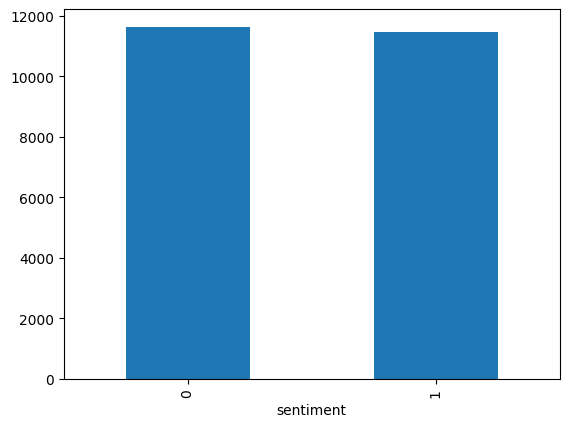

In [46]:
train_ds.sentiment.value_counts().plot.bar()


<Axes: xlabel='sentiment'>

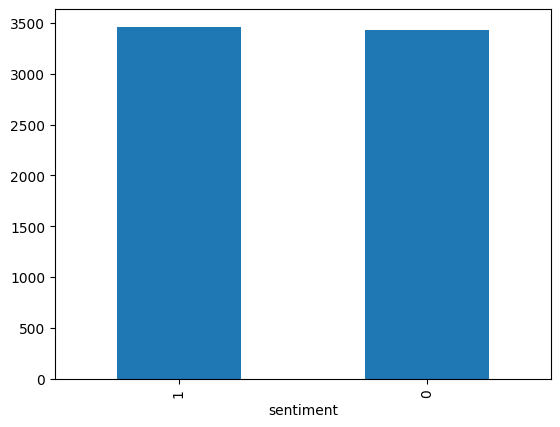

In [47]:
val_ds.sentiment.value_counts().plot.bar()

### Run training process 


In [49]:

def perform_inference(specific_model, k = 10):

   yhat = specific_model.predict(test_tfds)
   yhat_prob = copy.deepcopy(yhat)
   yhat[yhat >=0.5] = 1
   yhat[yhat < 0.5] = 0 

   pr(y_test, yhat).numpy()
   pr.update_state(y_test,yhat)
   p.update_state(y_test,yhat)
   r.update_state(y_test,yhat)

   for i, (sentence, sentiment) in enumerate(test_tfds.take(k)):
      print(f"Prediction/Real {int(yhat[i][0])}/{sentiment} - Sentence :'{sentence}'")


   results = "AUC/PR",pr(y_test, yhat).numpy()," | Precision : ",p.result().numpy(), " | Recall : ",r.result().numpy()
   print(results)


   return yhat, yhat_prob, results

# Using a pretrained model as embedding source

In [50]:
num_labels = len(train_ds.sentiment.unique())  # number of labels for your classification task

display(train_ds)
display(val_ds)

raw_review  \
0      This was an absolutely terrible movie. Don't b...   
1      I have been known to fall asleep during films,...   
2      Mann photographs the Alberta Rocky Mountains i...   
3      This is the kind of film for a snowy Sunday af...   
4      As others have mentioned, all the women that g...   
...                                                  ...   
24994  The last Tarzan film starring Johnny Weissmull...   
24995  I have a severe problem with this show, severa...   
24996  The year is 1964. Ernesto "Che" Guevara, havin...   
24998  When I saw this trailer on TV I was surprised....   
24999  First of all, Riget is wonderful. Good comedy ...   

                                                  review  sentiment  size  \
0      absolutely terrible movie donot lured christop...          0    66   
1      known fall asleep films usually due combinatio...          0    50   
2      mann photographs rocky mountains superb fashio...          0    76   
3      kind film snowy sunday afternoon rest world go...          1    45   
4      others mentioned women go nude film mostly abs...          1    39   
...                                                  ...        ...   ...   
24994  last tarzan film starring johnny weissmuller l...          0   126   
24995  severe problem show several actually simple li...          0   272   
24996  year oneninesixfour ernesto che guevara cuban ...          1    95   
24998  saw trailer tv surprised may twozerozeroeight ...          0    76   
24999  first riget wonderful good comedy mystery thri...          1   158   

       raw_size  
0           116  
1           112  
2           132  
3            88  
4            81  
...         ...  
24994       255  
24995       518  
24996       169  
24998       169  
24999       296  

[23107 rows x 5 columns]

raw_review  \
5807   I stumbled upon this movie by chance. I was tr...   
24761  A guy, with the unlikely name of Shy Walker, l...   
21868  As a parent of two girls(14 and 11) I have gra...   
9208   Together with the even more underrated , The S...   
10422  The Cheesiest movie I've ever seen, Not scary,...   
...                                                  ...   
5252   It is sad to have to say that a film is truly ...   
23848  The recent history of Hollywood remakes of gho...   
4932   I never heard of architect, Louis Kahn, until ...   
22961  This is a truly heartwarming film not just abo...   
4679   For me this wonderful rollercoaster of a film ...   

                                                  review  sentiment  size  \
5807   stumbled upon movie chance traveling years bac...          1    65   
24761  guy unlikely name shy walker looks two daughte...          0   237   
21868  parent two girls onefour oneone grave doubts s...          0   160   
9208   together even underrated sun shines bright wag...          1    53   
10422  cheesiest movie i've ever seen scary bad onest...          0    64   
...                                                  ...        ...   ...   
5252   sad say film truly awful one tries find ways a...          0    68   
23848  recent history hollywood remakes ghost horror ...          1   112   
4932   never heard architect louis kahn documentary a...          1    78   
22961  truly heartwarming film love learning values l...          1    24   
4679   wonderful film bears repeated pleasurable view...          1   127   

       raw_size  
5807        147  
24761       435  
21868       300  
9208         89  
10422       119  
...         ...  
5252        121  
23848       222  
4932        122  
22961        55  
4679        215  

[6890 rows x 5 columns]

Convert pandas to tf.dataset

In [51]:
if TUNNING:
    train_ds = train_ds.sample(10000)
    
train_tfds = tf.data.Dataset.from_tensor_slices(
        (
            train_ds.review.tolist(), 
            train_ds.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(train_ds)).prefetch(tf.data.AUTOTUNE)
#train_tfds = train_tfds.map(lambda x, y :  (tf.strings.split(x),y))

dev_tfds = tf.data.Dataset.from_tensor_slices(
        (
            val_ds.review.tolist(),
            val_ds.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(val_ds)).prefetch(tf.data.AUTOTUNE)
    
#dev_tfds = dev_tfds.map(lambda x, y :  (tf.strings.split(x),y))

#if TUNNING == False:
test_tfds = tf.data.Dataset.from_tensor_slices(
        (
            test_ds.review.tolist(), 
            test_ds.sentiment.tolist()
        )
    )

#test_tfds = test_tfds.map(lambda x, y :  (tf.strings.split(x),y))

# Getting test labels
y_test = []
for _, y in test_tfds:
    y_test.append(y)
y_test = np.array(y_test).reshape((len(y_test),1))

test_tfds = test_tfds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


for i, o in train_tfds.take(1):
    print(i)
    print(o)

tf.Tensor(
[b'ten year old liked hard get christopher lloyd played way top suit tedious unfunny sorry see jeff daniels'
 b"actually trilogy three somerset maugham's short tales first one verger onefive minutes long enjoyable oneseven years albert foreman laid church job canot read write opens tobacco shop course br br second mr know actually story read school six years ago instantly forgotten heard familiar introduction another onefive minute one also good worked better film book perhaps that's onefour last time afterall br br threerd one nearly let almost hour length simply drags bad quick snappy last two watched first quarter hour skipped forward last quarter hour found still made sense really hadnot missed thing br br overall give eight nine six onezero respectively"
 b"utter dreck got onesix minute twoseven second point gave i'd given negative number review possible although fitting word unlike sizzle could see practically feel macmurray stanwyck original chemistry dumb ol' crenna 

In [52]:
for i, o in train_tfds.take(1):
    print(i)
    print(o)

tf.Tensor(
[b'rented movie tonight looked like fun movie figured really couldnot go wrong concept ex girlfriend super powers br br movie confused pointless br br seemed every turn writer kept throwing junk also writer kept throwing way much toilet humor sexual situations teenage boy could love br br seems could simple draw story fatal attraction super hero guess br br fun romantic comedy advertised could take child see would embarrassed seeing date br br writer could done basic story around high concept cleaned movie might fighting chance br br serious waste time br br b'
 b"opinion one greatest movies ever made america deserved every single award place afi top onezerozero list though shamefully low imdb top twofivezero list writing enjoy acting highest calibre voight hoffman superb match well drawn characterizations inventive direction editing cinematography love much schlesinger paints vivid always credible picture late sixzeros new york city scene many victims struggling overcome pe

In [53]:
preprocessor = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")

def process_text(input_text, sentiment):
    process_text = preprocessor(input_text)
    return process_text, sentiment

train_tfds = train_tfds.map(process_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dev_tfds = dev_tfds.map(process_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)

if TUNNING == False:
    test_tfds = test_tfds.map(process_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)

for i, o in train_tfds.take(1):
    print(i)
    print(o)

{'input_type_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[  101,  2934,  4127, ...,  5906,  7436,   102],
       [  101,  2079, 27877, ...,  2465,  3772,   102],
       [  101,  2471,  2274, ...,  2050, 17319,   102],
       ...,
       [  101,  2822,  5745, ...,     0,     0,     0],
       [  101,  2470,  2143, ...,  3496, 18257,   102],
       [  101,  1045,  1005, ...,     0,     0,     0]], dtype=int3

In [54]:
for i, o in dev_tfds.take(1):
    print(i)
    print(o)

{'input_type_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[  101, 12975, 14523, ...,     0,     0,     0],
       [  101,  1057,  5603, ...,  5110,  1038,   102],
       [  101,  3928,  2143, ...,  2028,  3087,   102],
       ...,
       [  101,  2516,  2143, ...,     0,     0,     0],
       [  101,  6945,  2307, ...,  2111,  7230,   102],
       [  101,  2931,  2767, ...,     0,     0,     0]], dtype=int3

In [55]:
import keras
#https://www.tensorflow.org/tfmodels/nlp/fine_tune_bert
#https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/

#@keras.saving.register_keras_serializable(package="AttentionSentimentModelClass", name="AttentionSentimentModelClass")
class AttentionSentimentModelPretrained(tf.keras.Model):
    def __init__(
        self, 
        n_classes,
        dropout_rate,
        num_dense_layers,
        dense_units_list,
        train_emb = True,
        **kwargs):
        super(AttentionSentimentModelPretrained, self).__init__()

        self.dropout_rate = dropout_rate
        self.embedding_model = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-128-a-2/2", trainable=train_emb)#


        self.num_dense_layers = num_dense_layers

        if self.num_dense_layers > 0:
            self.dense_layers = [Dense(dense_units_list[i], activation='relu') for i in range(self.num_dense_layers)]

            if self.num_dense_layers > 1:
                self.dropout_layers = [Dropout(dropout_rate[i]) for i in range(self.num_dense_layers-1)]
                self.batch_norms = [BatchNormalization() for i in range(self.num_dense_layers-1)]

        self.output_dense = Dense(n_classes, activation='sigmoid')
        self.flatten = tf.keras.layers.Flatten()

    def call(self, inputs):

        # Step 2: Tokenize the entire batch
        outputs = self.embedding_model(inputs)

        x = outputs["pooled_output"]      # [batch_size, 128].  
        if self.num_dense_layers > 0:
            for i in range(self.num_dense_layers):
                x = self.dense_layers[i](x)
                if i < (self.num_dense_layers - 1) and  self.num_dense_layers > 1:
                    x = self.batch_norms[i](x)
                    x = self.dropout_layers[i](x)
        classes  = self.output_dense(x)


        return classes

# test_sentiment_model =AttentionSentimentModelPretrained(n_classes = 1)
# test_sentiment_model.compile(optimizer=Adam(learning_rate=0.0001), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.AUC()])
# for i, o in train_tfds.take(1):
#     test_sentiment_model(i)
# test_sentiment_model.summary()


## Selecting the Hyperparam range

In [56]:
def get_model_tunning_random_search(hp):

    pr = tf.keras.metrics.AUC(curve="PR")
    p = tf.keras.metrics.Precision()
    r = tf.keras.metrics.Recall()

    n_dense_layers = hp.Int('max_n_dense', 0, 2)
    dense_dropout_units_list = []
    dense_units_list = []

    if n_dense_layers > 0:
        dense_units_list =  [hp.Int('dense_units_'+str(i), 32, 128) for i in range(n_dense_layers)]
        if n_dense_layers > 1:
            dense_dropout_units_list =  [hp.Float('dropout_units_'+str(i), 0.0, 0.5, step = 0.1) for i in range(n_dense_layers-1)]
        
    hp_learning_rate = hp.Float('learning_rate', 0.000001, 0.001)


    model =AttentionSentimentModelPretrained(
        n_classes = 1, 
        dropout_rate = dense_dropout_units_list,
        num_dense_layers = n_dense_layers,
        dense_units_list = dense_units_list
        )
  

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.AUC(), pr, p, r])
    for i, o in train_tfds.take(1):
        model(i)

    return model

In [57]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/hyperparam_range_att/")
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', start_from_epoch=20, patience=10)

tuner = kt.RandomSearch(
    get_model_tunning_random_search,
    kt.Objective('val_auc', direction="max"),
    max_trials=30, 
    directory=r"Hyperparam_range",
    project_name=f'Random_search_att',
    )

if TUNNING:
    tuner.search(train_tfds,  epochs=100, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 


Reloading Tuner from Hyperparam_range/Random_search_att/tuner0.json


## Tunning on range

In [58]:
version = "_pretrained_v2"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_tunning{version}/")
def get_model_tunning(hp):

    pr = tf.keras.metrics.AUC(curve="PR")
    p = tf.keras.metrics.Precision()
    r = tf.keras.metrics.Recall()

    n_dense_layers = 0# hp.Int('max_n_dense', 0, 2)
    dense_dropout_units_list = []
    dense_units_list = []

    # if n_dense_layers > 0:
    #     dense_units_list =  [hp.Int('dense_units_'+str(i), 32, 100) for i in range(n_dense_layers)]
    #     if n_dense_layers > 1:
    #         dense_dropout_units_list =  [hp.Float('dropout_units_'+str(i), 0.0, 0.5, step = 0.1) for i in range(n_dense_layers-1)]
        
    hp_learning_rate = hp.Float('learning_rate', 0.00001, 0.001)


    model =AttentionSentimentModelPretrained(
        n_classes = 1, 
        dropout_rate = dense_dropout_units_list,
        num_dense_layers = n_dense_layers,
        dense_units_list = dense_units_list
        )
        

    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.AUC(), pr, p, r])
    for i, o in train_tfds.take(1):
        model(i)

    return model

tuner = kt.BayesianOptimization(
        get_model_tunning,
        objective= [kt.Objective('val_loss', direction="min"),kt.Objective('val_auc_1', direction="max")],
        max_trials = 10,
        directory=r"Hyperparam_tunning",
        project_name=f'keras_tunning{version}',
    )

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
tuner.search(train_tfds,  epochs=100, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[stop_early, tensorboard_callback]) 

Reloading Tuner from Hyperparam_tunning/keras_tunning_pretrained_v2/tuner0.json


In [59]:
for i, trials in enumerate(tuner.oracle.get_best_trials(num_trials=10)):
    print(f"[{i}] Trial id :{trials.trial_id} | Score :{trials.score} -->",trials.hyperparameters.values)

[0] Trial id :01 | Score :-0.606797844171524 --> {'learning_rate': 0.0001848369072255577}
[1] Trial id :06 | Score :-0.6004527807235718 --> {'learning_rate': 8.945443586407591e-05}
[2] Trial id :00 | Score :-0.5978766977787018 --> {'learning_rate': 0.00022712421994644538}
[3] Trial id :08 | Score :-0.5950461328029633 --> {'learning_rate': 0.00045281527480601304}
[4] Trial id :04 | Score :-0.5913116335868835 --> {'learning_rate': 1e-05}
[5] Trial id :05 | Score :-0.5785797834396362 --> {'learning_rate': 0.0003666573717114574}
[6] Trial id :09 | Score :-0.5634914636611938 --> {'learning_rate': 0.00029662925766712486}
[7] Trial id :03 | Score :-0.5350495278835297 --> {'learning_rate': 0.001}
[8] Trial id :07 | Score :-0.033421993255615234 --> {'learning_rate': 0.0009044362982960243}
[9] Trial id :02 | Score :0.07652926445007324 --> {'learning_rate': 0.0006401330724011251}


In [60]:
pr = tf.keras.metrics.AUC(curve="PR")
p = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()

n_dense_layers = 0
dense_dropout_units_list = []
dense_units_list = []


hp_learning_rate = 0.000001

selected_model =AttentionSentimentModelPretrained(
    n_classes = 1, 
    dropout_rate = dense_dropout_units_list,
    num_dense_layers = n_dense_layers,
    dense_units_list = dense_units_list,
    train_emb = True
    )
    
if TRAIN_MODE:  
    selected_model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.AUC(), pr, p, r])
    for i, o in train_tfds.take(1):
        selected_model(i)

    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_tunning{version}/selected_model_train_emb_true")
    selected_model.fit(train_tfds,  epochs=200, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[ tensorboard_callback]) 
    selected_model.save_weights(f'./checkpoints/selected_model_{version}')

else:
    selected_model.load_weights(f'./checkpoints/selected_model_{version}')


In [61]:
yhat, yhat_prob, first_results = perform_inference(specific_model = selected_model)

63/63 [==============================] - 4s 50ms/step
Prediction/Real 0/[0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 0
 0 1 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0
 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1
 1 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1
 1 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 0 1 0 1
 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 0
 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0] - Sentence :'{'input_type_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1,

# Manual Error analysis

Actual results are : AUC/PR 0.8387004  | Precision :  0.8682096  | Recall :  0.8651871


Add our predictions along the original data¶


In [62]:
test_ds["predicted_prob"] = yhat_prob
test_ds

raw_review  \
18865  I rented this movie for about $1.50 - the most...   
5874   So the Koreans are now knocking off American h...   
23776  I saw this movie on a fluke.I was standing on ...   
20511  As an indie filmmaker, I try to at least make ...   
7231   Spoiler Alert I worked as an extra on this Lif...   
...                                                  ...   
14233  sure this movie may have had its funny moments...   
21369  Stephanie Meyer is going to be so ticked! Now,...   
10661  The screen-play is very bad, but there are som...   
11716  Definitely worth watching.<br /><br />Ten diff...   
2934   I've always said that there's nothing to beat ...   

                                                  review  sentiment  size  \
18865  rented movie one fivezero complete waste money...          0    78   
5874   koreans knocking american horror flicks style ...          1    68   
23776  saw movie fluke standing fourtwond street wait...          1    84   
20511  indie filmmaker try least make decent film pie...          0   116   
7231   spoiler alert worked extra lifetime tv movie f...          1   131   
...                                                  ...        ...   ...   
14233  sure movie may funny moments sat question peop...          0    77   
21369  stephanie meyer going ticked book breaking daw...          1    83   
10661  screen play bad action sequences really liked ...          0    17   
11716  definitely worth watching br br ten different ...          1    98   
2934   i've always said there's nothing beat original...          0    79   

       raw_size  predicted_prob  
18865       147        0.008257  
5874        136        0.194419  
23776       149        0.976586  
20511       233        0.013479  
7231        237        0.848536  
...         ...             ...  
14233       146        0.011645  
21369       160        0.931055  
10661        35        0.785393  
11716       167        0.965464  
2934        165        0.021768  

[16075 rows x 6 columns]

Real value of class is 0 or 1, error is how far our prediction is from this.



In [63]:
test_ds['error'] = abs(test_ds['sentiment'] - test_ds['predicted_prob']) 
pd.set_option('display.max_colwidth', 2000)    


test_ds.head(20)

raw_review  \
18865                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          I rented this movie for about $1.50 - the most complete waste of money (and time) I have ever spent. It's LAME! I couldn't believe how they could come up with something like this.<br /><br />The plot... there is no plot. Everything you'd expect to happen, it does, only in a worse way. The acting was horrible. My dog could've done better. The special effects have no effect whatsoever - except inducing complete disbelief. And the cheesy lines.... I mean, why even bother? <br /><br />The only credit I can give this piece of sh*t are the opening scenes. They were actually quite pretty. And one of the reasons why I decided to rent this. The graphics shown there are probably the best and most realistic CG of the entire film.<br /><br />Total Reality gets 1 out of 10 for not being able to mark it lower.   
5874                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        So the Koreans are now knocking off American horror flicks. But they are doing so with style. DOLL MASTER is a close copy of PUPPETMASTER and DOLLS, and even has a little CHILD'S PLAY going for it. Several young adults are invited to attend a special event at a gallery filled with dolls, only to find they are targets of a vengeful spirit. The dolls come to life and do some pretty nasty things to the kids. The gore level is reasonably high, the photography and set design and production values are first rate, the acting isn't all that bad, and the scares are definitely there. DOLL MASTER may not be in the same league with A TALE OF TWO SISTERS or even DEAD FRIEND, but it's close. Give it a wat

Sort the items in decreasing order of error amount


In [64]:
sorted_df = test_ds.sort_values(by=['error'], ascending=False)
sorted_df

raw_review  \
1459                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Greyfriars Bobby was NOT a westie - Bobby was a skye terrier. A highlight of my childhood day trips to Edinburgh was to go to the monument to Bobby. I grew up with the story of the valiant and loyal little dog, as every child in my generation did, and I remember lining up with my mum outside the cinema - with many, many other Dundee children and their mums - to see the wonderful Disney film. How could a movie based on such a wonderful story have been made using a Westie, for heaven's sake. That's like making a movie about the life of Robert Burns, for instance, and portraying him as an Englishman. I say,give Bobby back his breed!   
13290                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Yes,the movie is not a piece of art but the first time I watched it I was 10 years old,my parents were out and I stayed home with my two brothers.It was May 1970(I know that because I found a note about the cycle of horror movies that one network had).It's one of the most vivid memories I have with the guys.We ended all in one bed and covered up to the head! Our very first horror movie! We kept talking about it for years and laughing about the moment.Those were horror movies.Nowadays horror movies are always the same.Or was it better when we were kids enjoying without analyzing the plot and the cast and the dialogs? Most sure it was that.But

False positive cases

In [65]:
# sorted_df[ sorted_df['sentiment']==0].head(20)


False negatives

In [66]:
sorted_df[ sorted_df['sentiment']==1].head(20)


raw_review  \
678                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           If you're looking for a not-so-serious mob movie, with a female as the lead, you're in the right place. Pfieffer has acted much better than this. You can see she has matured beyond this picture.<br /><br />When I first picked this movie up, I expected Pfeiffer was poorly miscast, however, she plays her mob wife role to the hilt. Not a bad performance from Baldwin, either.<br /><br />If you don't pay attention to the hair, you might enjoy this movie. But don't take it too seriously...   
7157                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       This was Laurel and Hardy's last silent film for Roach Studios. However, since the public had a real thirst for "talkies", this same short was re-made by the team just a few years later with only a few small plot changes. LAUGHING GRAVY was essentially the same plot except that Stan and Ollie were trying to hide a cute puppy from their grouchy landlord--not a goat like in ANGORA LOVE. This whole goat angle is the worst part of the film. While you could understand the boys wanting to keep a cute little dog (after all, it is snowy outside), why exactly they bring a goat home is just contrived and pointless. According to the plot, the goat followed them home and so they got tired of shooing it away and kept it. Huh?! This just doesn't make any sense--if it had been a giraffe or a cow, would they have done the same thing?! Apart from being an unconvincing plot, the movie itself is pure Laurel and Hardy, with a familiar plot and familiar roles for the comedians. This film features quite a few laughs, but unfortunately isn't one of their better films to wrap up their silent careers. This aspect of their careers just seems

Most correct and confident predictions


In [67]:
test_ds.sort_values(by=['error'], ascending=True).head(20)

raw_review  \
18932                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I loved this film. It was so intelligent but it also had some great action sequences, without basing the movie solely around them. Quinn, Sutherland and Kingsley all put in fantastic performances and there are enough twists to keep anyone interested. The ending was great as well.   
19977                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     I had the chance to watch Blind Spot in Barcelona and I enjoyed it tremendously. I thought it to be one of the most captivating movies that I'd seen for a long time. One of the best points of the film was to meet new fresh faces and great actors behind them in unexpectedly and brilliantly filmed great locations. The three heroes share a chemistry on screen that runs all across the film making it so thrilling. They are set on outstanding landscapes spotted by such an original eye (the DOP's work is just great) that makes you feel like you are discovering them for the first time. The mood of the desert floods everywhere and even the scenes filmed in the streets of Los Angeles or San Francisaco seem to be a natural extension of it. The story rides you smoothly through all these beautiful settings to lead you to a bitter-sweet ending, being the perfect climax for this perfect journey. The construction of the film itself is a master craft. The skilled use of innovative resources (like stills stitching Danny's memories into the film) will compare to those hand-made pieces of work so rare and so enjoyable. Blind Spot achieves to capture the essence of the desert taking you to an universal common ground where anyone of us can feel bei

### Check sentence size

In [68]:
test_ds["unique_words"] = test_ds.review.apply(lambda x : len(set(x.split())))
test_ds.head(1)

raw_review  \
18865  I rented this movie for about $1.50 - the most complete waste of money (and time) I have ever spent. It's LAME! I couldn't believe how they could come up with something like this.<br /><br />The plot... there is no plot. Everything you'd expect to happen, it does, only in a worse way. The acting was horrible. My dog could've done better. The special effects have no effect whatsoever - except inducing complete disbelief. And the cheesy lines.... I mean, why even bother? <br /><br />The only credit I can give this piece of sh*t are the opening scenes. They were actually quite pretty. And one of the reasons why I decided to rent this. The graphics shown there are probably the best and most realistic CG of the entire film.<br /><br />Total Reality gets 1 out of 10 for not being able to mark it lower.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  \
18865  rented movie one fivezero complete waste money time ever spent lame couldnot believe could come something like br br plot plot everything expect happen worse way acting horrible dog could've done better special effects effect whatsoever except inducing complete disbelief cheesy lines mean even bother br br credit give piece sh opening scenes actually quite pretty one reasons decided rent graphics shown probably best realistic cg entire film br br total reality gets one onezero able mark lower   

       sentiment  size  raw_size  predicted_prob     error  unique_words  
18865          0    78       147        0.008257  0.008257            69

Shortest and longest reviews

In [69]:
sorted_size_df = test_ds.sort_values(by=['size'], ascending=True)
sorted_size_df.head(20)

raw_review  \
15391                                                                                                         More suspenseful, more subtle, much, much more disturbing....   
163                                                                                                                       I hope this group of film-makers never re-unites.   
3076                                                                                                      This is a great movie. Too bad it is not available on home video.   
11653                                                                                                                   Primary plot!Primary direction!Poor interpretation.   
4981                                                                                                    Brilliant and moving performances by Tom Courtenay and Peter Finch.   
19035                                                                         This is a good film. This is very funny. Yet after this film there were no good Ernest films!   
14429                                                   This is the greatest movie ever. If you have written it off with out ever seeing it. You must give it a second try.   
12768                                                       a mesmerizing film that certainly keeps your attention... Ben Daniels is fascinating (and courageous) to watch.   
19009                                                       This is a terrible movie, don't waste your money on it. Don't even watch it for free. That's all I have to say.   
20126                           This movie turned out to be better than I had expected it to be. Some parts were pretty funny. It was nice to have a movie with a new plot.   
10670                                            For pure gothic vampire cheese nothing can compare to the Subspecies films. I highly recommend each and every one of them.   
17376                                                                    If you like Pauly Shore, you'll love Son in Law. If you hate Pauly Shore, then, well...I liked it!   
3609                                          Don't waste your time and money on it. It's not quite as bad as "Adrenalin", by the same director but that's not saying much.   
5487                                     The plot was really weak and confused. This is a true Oprah flick. (In Oprah's world, all men are evil and all women are victims.)   
1029   What a stinker!!! I swear this movie was written by a computer that took a whole pile of other movies and merged them all together into this platypus of film. Ouch!   
763                                      A great film in its genre, the direction, acting, most especially the casting of the film makes it even more powerful. A must see.   
5138                                  Very intelligent language usage of Ali, which you musn't miss! In one word: (eeh sentence...) Wicked, so keep it real and pass it on!   
1984         The acrobatics mixed with haunting music, make one spectacular show. The costumes are vibrant and the performances will just boggle your mind! Simply amazing!   
14266          I really enjoyed this movie... In My DVD collection of baseball movies... Reminded me how great the sport truly is... Whether it's here in America or Japan.   
5897                  The Buddy Holly Story is a great biography with a super performance from Gary Busey. Busey did his own singing for this film and he does a great job.   

                                                                                                            review  \
15391                                                                      suspenseful subtle much much disturbing   
163                                                                                   hope group film makers never   
3076                                                                          great movie bad available home video   
11653        

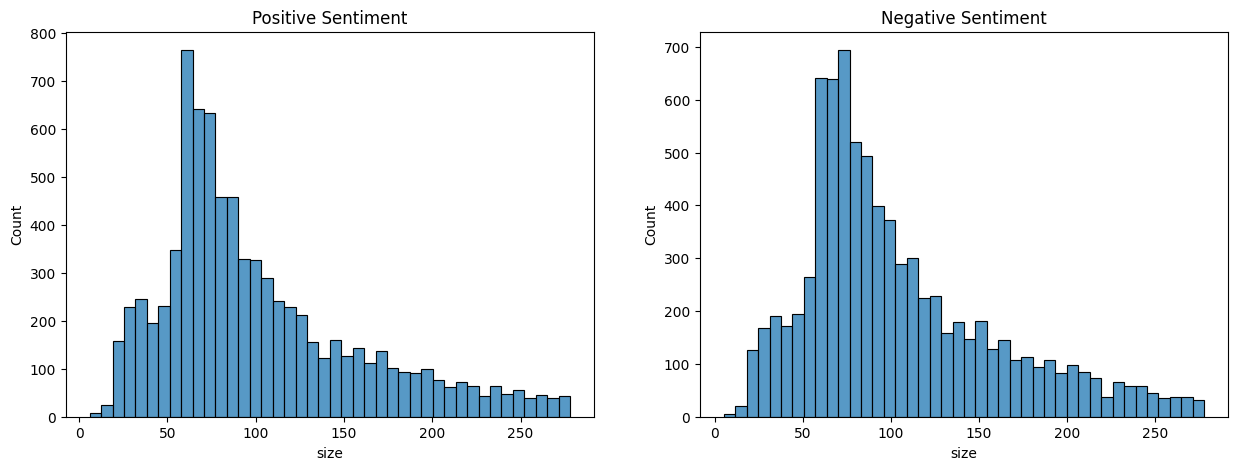

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
test_ds["predicted_class"] = 0
test_ds.loc[test_ds['predicted_prob'] >= 0.5, 'predicted_class'] = 1
# Plot for positive sentiment
sns.histplot(data=test_ds[test_ds['sentiment'] == 1], x='size', ax=axes[0])

axes[0].set_title('Positive Sentiment')

# Plot for negative sentiment
sns.histplot(data=test_ds[test_ds['sentiment'] == 0], x='size', ax=axes[1])
axes[1].set_title('Negative Sentiment')

plt.show()

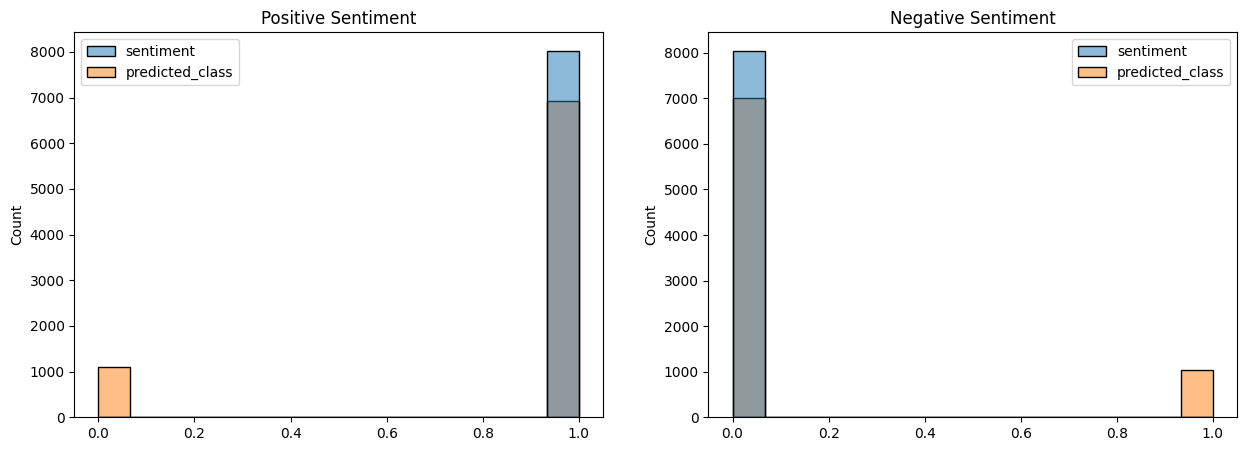

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=test_ds[test_ds['sentiment'] == 1][['sentiment', 'predicted_class']], ax=axes[0])

axes[0].set_title('Positive Sentiment')

# Plot for negative sentiment
sns.histplot(data=test_ds[test_ds['sentiment'] == 0][['sentiment', 'predicted_class']], ax=axes[1])
axes[1].set_title('Negative Sentiment')

plt.show()

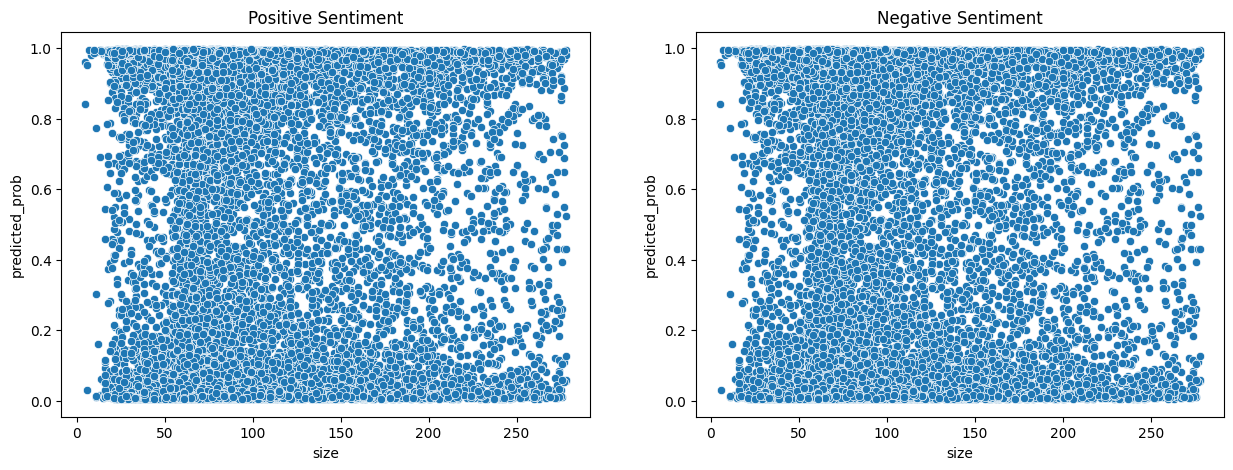

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for positive sentiment
sns.scatterplot(data=test_ds, x='size', y='predicted_prob', ax=axes[0])
axes[0].set_title('Positive Sentiment')

# Plot for negative sentiment
sns.scatterplot(data=test_ds, x='size', y='predicted_prob', ax=axes[1])
axes[1].set_title('Negative Sentiment')


plt.show()

### Analyze words frequency 

In [73]:
test_ds.sort_values(by=['error'], ascending=False).head(3)
# It seems that some stop words such as "NOT". 

raw_review  \
1459                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Greyfriars Bobby was NOT a westie - Bobby was a skye terrier. A highlight of my childhood day trips to Edinburgh was to go to the monument to Bobby. I grew up with the story of the valiant and loyal little dog, as every child in my generation did, and I remember lining up with my mum outside the cinema - with many, many other Dundee children and their mums - to see the wonderful Disney film. How could a movie based on such a wonderful story have been made using a Westie, for heaven's sake. That's like making a movie about the life of Robert Burns, for instance, and portraying him as an Englishman. I say,give Bobby back his breed!   
13290                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Yes,the movie is not a piece of art but the first time I watched it I was 10 years old,my parents were out and I stayed home with my two brothers.It was May 1970(I know that because I found a note about the cycle of horror movies that one network had).It's one of the most vivid memories I have with the guys.We ended all in one bed and covered up to the head! Our very first horror movie! We kept talking about it for years and laughing about the moment.Those were horror movies.Nowadays horror movies are always the same.Or was it better when we were kids enjoying without analyzing the plot and the cast and the dialogs? Most sure it was that.But

/tmp/ipykernel_20906/978711218.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_20906/978711218.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_20906/978711218.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_20906/978711218.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_20906/978

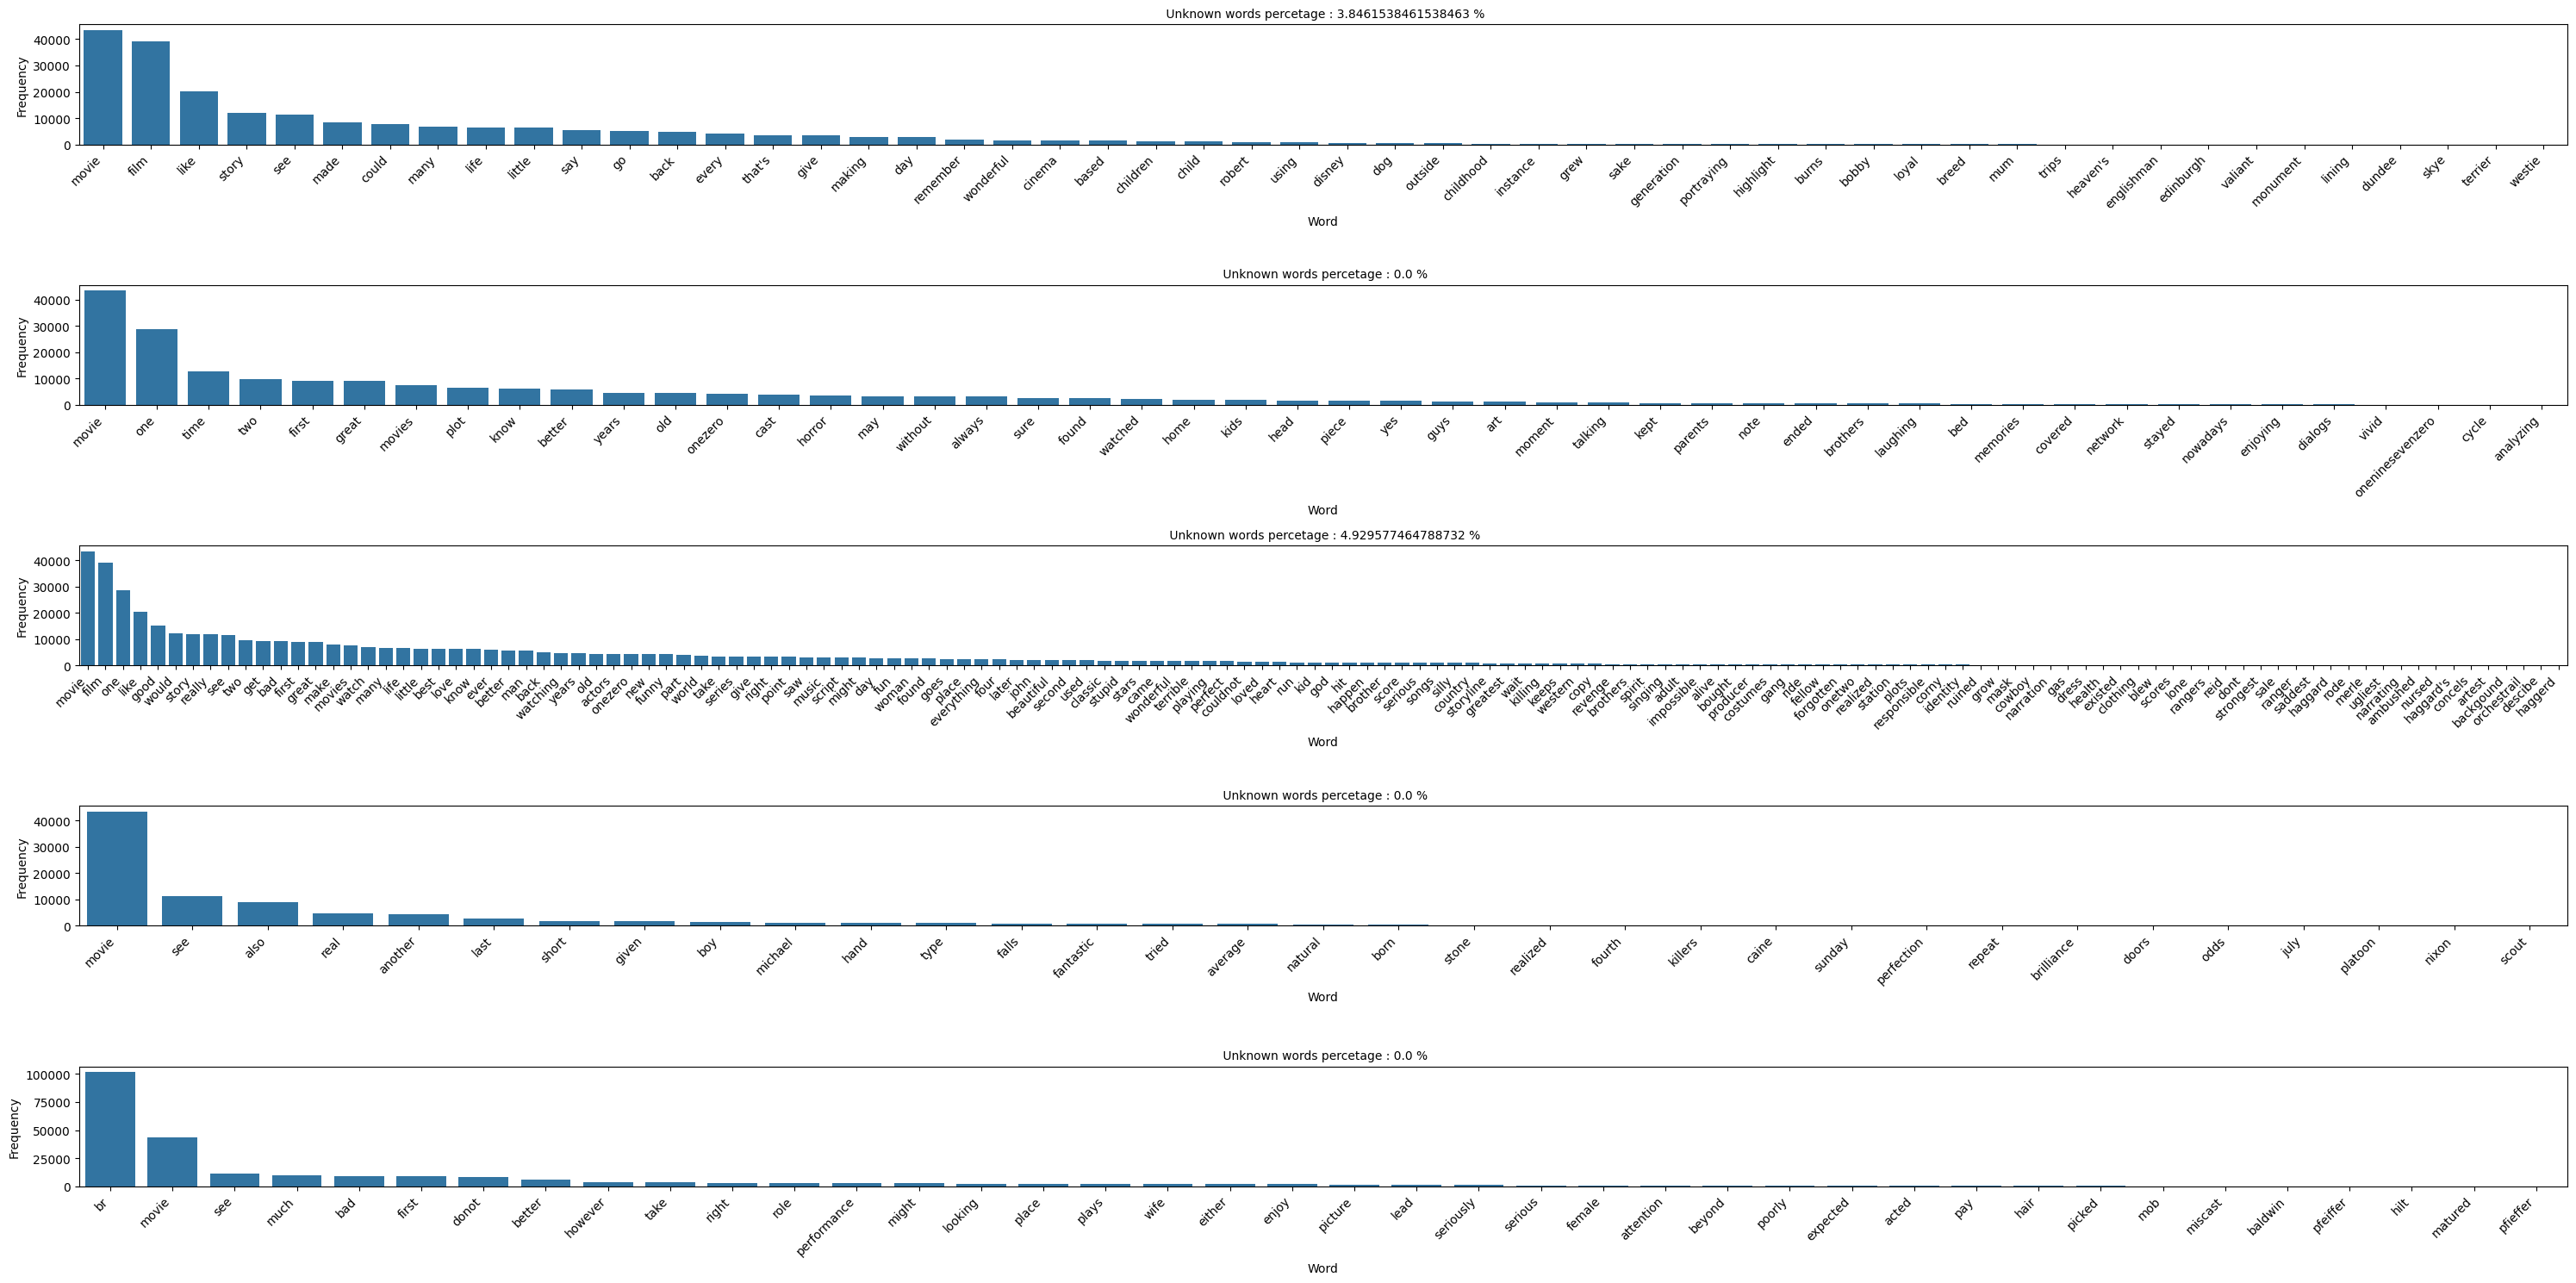

In [74]:

def get_words_plot_by_sentences(list_of_sentences):

    num_sentences = len(list_of_sentences)
    fig, axes = plt.subplots(num_sentences, 1, figsize=(30, num_sentences * 3))  


    for i, review in enumerate(list_of_sentences):
        sentence_word_frequency = {}
        unkwnown_words = 0
        for w in review.split():
            if w in word_frequency.keys():
                sentence_word_frequency[w] =  word_frequency[w] 
            else:
                sentence_word_frequency[w] = 0
                unkwnown_words +=  1


        word_frequency_df = pd.DataFrame(list(sentence_word_frequency.items()), columns=['Word', 'Frequency'])
        word_frequency_df = word_frequency_df.sort_values('Frequency', ascending=False)
        sns.barplot(x='Word', y='Frequency', data=word_frequency_df, ax=axes[i])
        axes[i].set_title(f" Unknown words percetage : {float(unkwnown_words/len(sentence_word_frequency))*100} %", fontsize=10)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    # Show the plot
    plt.show()

n_words = 5
#get_words_plot_by_sentences(train_dataset.head(n_words).review.values.tolist())
get_words_plot_by_sentences(test_ds.sort_values(by=['error'], ascending=False).head(n_words).review.values.tolist())


### Check for tags

In [75]:
tag_patterns = [
    r'<[^>]+>',       # HTML/XML-like tags
    r'\[.+?\]',       # Custom tags (e.g., [custom])
    r'(https?://[^\s]+)',             # URLs starting with http or https
    r'(www\.[^\s]+)'                  # URLs starting with www
]

def extract_tags(text):
    tags_found = []
    for pattern in tag_patterns:
        tags_found.extend(re.findall(pattern, text))
    return tags_found

# Apply the function to each sentence
train_ds['tags'] = train_ds['review'].apply(extract_tags)
val_ds['tags'] = val_ds['review'].apply(extract_tags)
test_ds['tags'] = test_ds['review'].apply(extract_tags)

In [76]:
train_ds.head(1)


raw_review  \
0  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              review  \
0  absolutely terrible movie donot lured christopher walken michael ironside great actors must simply worst role history even great acting could redeem movie's ridiculous storyline movie early nineties us propaganda piece pathetic scenes rebels making cases revolutions maria conchita alonso appeared phony pseudo love affair walken nothing pathetic emotional plug movie devoid real meaning disappointed movies like ruining actor's like christopher walken's good name could barely sit   

   sentiment  size  raw_size tags  
0          0    66       116   []

In [77]:
val_ds.head(1)


raw_review  \
5807  I stumbled upon this movie by chance. I was traveling a few years back and this movie was on some channel on cable at the hotel late one night. Not much else on and figured I watch it for about 20 to 30 minutes until I decided to go to bed. Needless to say, I stayed up and watched the complete movie. The plot was very interesting and does make you wonder if there had not been SS who did this or at least thought of doing it. I have been looking all over for this movie. I even sent and email to the production company, but the weren't sure that it would ever make it to DVD, but said there was always hope. If anyone finds this movie drop a note here where you found it, as I'd sure like to get a copy some day.   

                                                                                                                                                                                                                                                                                                                                                                                                                   review  \
5807  stumbled upon movie chance traveling years back movie channel cable hotel late one night much else figured watch twozero threezero minutes decided go bed needless say stayed watched complete movie plot interesting make wonder ss least thought looking movie even sent email production company werenot sure would ever make dvd said always hope anyone finds movie drop note found i'd sure like get copy day   

      sentiment  size  raw_size tags  
5807          1    65       147   []

In [78]:
test_ds.head(1)


raw_review  \
18865  I rented this movie for about $1.50 - the most complete waste of money (and time) I have ever spent. It's LAME! I couldn't believe how they could come up with something like this.<br /><br />The plot... there is no plot. Everything you'd expect to happen, it does, only in a worse way. The acting was horrible. My dog could've done better. The special effects have no effect whatsoever - except inducing complete disbelief. And the cheesy lines.... I mean, why even bother? <br /><br />The only credit I can give this piece of sh*t are the opening scenes. They were actually quite pretty. And one of the reasons why I decided to rent this. The graphics shown there are probably the best and most realistic CG of the entire film.<br /><br />Total Reality gets 1 out of 10 for not being able to mark it lower.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  review  \
18865  rented movie one fivezero complete waste money time ever spent lame couldnot believe could come something like br br plot plot everything expect happen worse way acting horrible dog could've done better special effects effect whatsoever except inducing complete disbelief cheesy lines mean even bother br br credit give piece sh opening scenes actually quite pretty one reasons decided rent graphics shown probably best realistic cg entire film br br total reality gets one onezero able mark lower   

       sentiment  size  raw_size  predicted_prob     error  unique_words  \
18865          0    78       147        0.008257  0.008257            69   

       predicted_class tags  
18865                0   []

There are no tags in the review but what about the raw_review ? Let's check for sentences with tags in the raw_review and understand how as it processed in the reviw that was used for training and validation

In [79]:
train_ds['raw_tags'] = train_ds['raw_review'].apply(extract_tags)
val_ds['raw_tags'] = val_ds['raw_review'].apply(extract_tags)
test_ds['raw_tags'] = test_ds['raw_review'].apply(extract_tags)

train_ds['has_raw_tags'] = train_ds['raw_tags'].apply(lambda x  : True if len(x)>0 else False)
val_ds['has_raw_tags'] = val_ds['raw_tags'].apply(lambda x  : True if len(x)>0 else False)
test_ds['has_raw_tags'] = test_ds['raw_tags'].apply(lambda x  : True if len(x)>0 else False)
train_ds

raw_review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I ca

In [80]:
train_ds[train_ds.has_raw_tags]

raw_review  \
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.   
7                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              The film is based on a genuine 1950s novel.<br /><br />Journalist Colin McInnes wrote a set of three "London novels": "Absolute Beginners", "City of Spades" and "Mr Love and Justice". I have read all three. The first two are excellent. The last, perhaps an experiment that did not come off. But McInnes's work is highly acclaimed; and rightly so. This musical is the novelist's ultimate nightmare - to see the fruits of one's mind being turned into a glitzy, badly-acted, soporific one-dimensional apology of a film that says it captures the spirit of 1950s London, and does nothing of the sort.<br /><br />Thank goodness Colin McInn

Get different tags in the training set and chegk some manually


In [81]:
train_tags = list(set(train_ds.raw_tags.sum()))

train_tags

['[rumor]',
 'http://www.imdb.com/title/tt0077247/.',
 '[1]',
 '[potential spoiler alert]',
 'www.imdb.com/title/tt0962736/awards',
 'http://www.imdb.com/name/nm0281661/',
 'www.imperialflags.blogspot.com',
 'http://tinyurl.com/ojhoyn',
 'www....yes,',
 'www.loveearth.com)<br',
 '[original]',
 '[Spoiler ahead]',
 'www.dvdbeaver.com/film/DVDCompare2/kingofmasks.htm<br',
 'www.intuitor.com/moviephysics/bleep.html',
 'http://www.happierabroad.com/Photojournals.htm<br',
 '[4]',
 'www.nixflix.com',
 'http://theoscarsblog.blogspot.com/2010/02/movie-review-secret-of-',
 'www.archambault.ca',
 '[Xizhao]',
 'www.imdb.com/title/tt0077713/',
 '[in this case, a minor one]',
 'http://en.wikipedia.org/wiki/Intentional_fallacy',
 '[1953]',
 '[Christine Tucci]',
 'www.imdb.com/title/tt1337580/',
 'www.youtube.com/watch?v=RMb4-hyet_Y',
 'www.angelfire.com/ny5/jbc33/',
 '[i.e. Eyes Wide Shut]',
 '[1974]',
 '[= gay-hating evangelist]',
 '[1931]',
 'http://www.imdb.com/title/tt1337580/',
 'www.dvdtalk.com

In [82]:
train_ds[train_ds.raw_review.str.contains('<hr>')]

raw_review  \
4052  First and foremost, Zorie Barber (Zeke), might be one of the worst actors I have ever seen. As a character that's supposed to be a hip, Village writer into the martial arts and proud of being mysterious, why is he so hyper, over-dramatic, and plain horrible? Did he know anything about his character before they started filming? Did the director? Don't the martial arts teach discipline? Aside from that, this film misses the target with its lame jokes and seen-it-already gross-out humor. Hand in toilet? <i>Trainspotting</i>. Masturbation? Hmm. <i>Fast Times at Ridgemont High</i>, <i>American Pie</i>, the list goes on.. .Bad dialogue: In one sequence, Eric says "it's none of my business <i>but</i> . ..." and 30 seconds later Mia says "why is this any of your business?" Bad editing: At least five minutes worth of film are wasted on NYC traffic shots. <hr>It's also impossible to believe that the four main male characters would be a tight-knit group of friends in any world. I can't comment on what makes everyone laugh, but if you enjoy low-brow, basic bathroom humor and insults, by all means, enjoy. If you want something a little smarter but on the same lines, see <i>Boomerang</i>. If you want a solid what-goes-around romantic comedy, go for <i>The Tao Of Steve</i>. But anyone who thinks <i>Whipped</i> is witty and an accurate portrayal dating, well, I cannot agree at all.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  \
4052  first foremost barber might one worst actors ever seen character that's supposed hip village writer martial arts proud mysterious hyper dramatic plain horrible know anything character started filming director donot martial arts teach discipline aside film misses target lame jokes seen already gross humor hand toilet trainspotting masturbation hmm fast times ridgemont high american pie list goes bad dialogue one sequence eric says none business threezero seconds later mia says business bad editing least five minutes worth film wasted nyc traffic shots hr also impossible believe four main male characters would tight knit group friends world canot comment makes everyone laugh enjoy low brow basic bathroom humor insults means enjoy want something little smarter lines see boomerang want solid goes around romantic comedy go steve anyone thinks whipped witty accurate portrayal dating well cannot agree   

      sentiment  size  raw_size tags  \
4052          0   135       231   []   

                                                                                 raw_tags  \
4052  [<i>, </i>, <i>, </i>, <i>, </i>, <i>, </i>, <hr>, <i>, </i>, <i>, </i>, <i>, </i>]   

      has_raw_tags  
4052          True

In [83]:
train_ds[train_ds.raw_review.str.contains('<em>')]

raw_review  \
6585  An occasionally surrealistic thriller that will push most people's buttons., the 4th Man is sure to offend anyone with a taste for the politically correct. The story's protagonist is a bisexual alcoholic Catholic writer, Gerard (Krabbe), with a seriously twisted sense of imagination. Verhoeven offers up<br /><br />Gerard has an example of everything wrong with the modern man. He's shiftless, delusional, unable to control his urges, afraid to commit to<br /><br />meaningful relationships, and utterly apathetic about life in general. As the character himself states at one point, he is a professional liar, unable to recall the truth.<br /><br />The movie opens with Gerard dreaming of spiders consuming Christ, and then waking to begin the long march to his own destruction. He chases off<br /><br />one man (a boyfriend presumably), then chases another at a train station. Later, at a lecture, he meets a woman who seems to want to help him, or<br /><br />perhaps she has more nefarious plans.. She quickly captures Gerard in her web, enticing him with sex and money, having plenty of both. She's also got<br /><br />secrets, like three dead husbands. Is she lonely, and genuinely looking for someone to nurture - or is she a deadly black widow, luring Gerard to his<br /><br />death? Will Garard be the 4th man she kills? The woman is Christine (Soutendijk), and Verhoeven does his best to keep you guessing what she's up to.<br /><br />This is an interesting movie, with a lot of sex and intrigue. It's similar to Verhoeven's<em>Basic instinct</em>, but has a lot more depth, and is certainly more shocking. There's a lot of very strong gay content, which may make some viewers squirm. Highly recommended for fans of intelligent<br /><br />psychological thrillers, or anyone looking for something entirely new.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              review  \
6585  occasionally surrealistic thriller push people's buttons fourth man sure offend anyone taste politically correct story's protagonist bisexual alcoholic catholic writer gerard krabbe seriously twisted sense imagination verhoeven offers br br gerard example everything wrong modern man he's delusional unable control urges afraid commit br br meaningful relationships utterly apathetic life general character states one point professional liar unable recall truth br br movie opens gerard dreaming spiders consuming christ waking begin long march destruction chases br br one man boyfriend presumably chases another train station later lecture meets woman seems want help br br perhaps nefarious plans quickly captures gerard web enticing sex money plenty also got br br secrets like three dead husbands lonely genuinely looking someone nurture deadly black widow luring gerard br br death fourth man kills woman 

In [84]:
train_ds[train_ds.raw_review.str.contains('www.gutenberg.org/ebooks/18137')]

raw_review  \
14303  Once upon a time there was a science fiction author named H. Beam Piper who wrote a classic book named "Little Fuzzy" which was about a man discovering a race of adorable little fuzzy humanoids on another planet. Mr. Piper died in 1964, but Hollywood and many of today's authors starting looting his grave before his cadaver got cold. This is the book where they got the idea for Ewoks from.<br /><br />Skullduggery is such a blatant ripoff of "Little Fuzzy" I can wonder why I'm the only who's ever noticed?<br /><br />But don't take my word for it. Here's a link to Project Guntenberg where you can download a copy of "Little Fuzzy" for free: http://www.gutenberg.org/ebooks/18137   

                                                                                                                                                                                                                                                                                                                                                                                                                                        review  \
14303  upon time science fiction author named h beam piper wrote classic book named little fuzzy man discovering race adorable little fuzzy another planet mr piper died oneninesixfour hollywood many today's authors starting looting grave got cold book got idea ewoks br br skullduggery blatant ripoff little fuzzy wonder i'm who's ever noticed br br donot take word here's link project download copy little fuzzy free http www org   

       sentiment  size  raw_size tags  \
14303          0    68       117   []   

                                                                                                      raw_tags  \
14303  [<br />, <br />, <br />, <br />, http://www.gutenberg.org/ebooks/18137, www.gutenberg.org/ebooks/18137]   

       has_raw_tags  
14303          True

In [85]:
train_ds[(train_ds.raw_review.str.contains('Not worth a rating')) & (train_ds.has_raw_tags)]

raw_review  \
15960  It is not often I watch a film that is as dreadful as this one. I continued to watch, every minute hoping that this was intended as a joke only to find it was meant to be taken seriously. Well, as seriously as this genre requests.<br /><br />The acting was disgraceful and the situations horribly contrived and clichéd. If a film was made in 1920 (for example) and had the quality of Hide & Seek (Cord) in its direction we would think that cinema back then was naive. As it happens, this film was made in 2000 and I have yet to see a film from the silent era that has as little charm as this one.<br /><br />Definitely not for the serious movie-goer.<br /><br />[Not worth a rating]   

                                                                                                                                                                                                                                                                                                                                                                                                                                        review  \
15960  often watch film dreadful one continued watch every minute hoping intended joke find meant taken seriously well seriously genre requests br br acting disgraceful situations horribly contrived clich film made oneninetwozero example quality hide seek cord direction would think cinema back naive happens film made twozerozerozero yet see film silent era little charm one br br definitely serious movie goer br br worth rating   

       sentiment  size  raw_size tags  \
15960          0    64       129   []   

                                                                     raw_tags  \
15960  [<br />, <br />, <br />, <br />, <br />, <br />, [Not worth a rating]]   

       has_raw_tags  
15960          True

In [86]:
test_tags = list(set(test_ds.raw_tags.sum()))

test_tags

['www.ABC.net.au/chaser.',
 'http://www.nixflix.com',
 'www.youtube.com/watch?v=2-W7evBEArs',
 '< Cough >',
 '[1936]',
 '[1]',
 '[WARNING: Some spoilers included, though it is a documentary.]',
 '[90%]',
 'http://www.imdb.com/title/tt0098238/',
 '<..>',
 '[6 (1+ - 6-)]',
 '[of the movie]',
 "[Seth Green, you'll get the nickname later]",
 'www.nixflix.com',
 'http://www.bbc.co.uk/',
 'www.bbc.co.uk/',
 'www.myspace.com/neizvestnostlab',
 'www.weatherpaparazzi.com/flooding.asp',
 '[1976]',
 '[Edward Norton]',
 'www.playitforwardoz.com/boyce.html',
 '[1973]',
 '[1954]',
 '<grin>',
 'www.screenonline.org.uk/tv/id/527213/index.html',
 '[1977]',
 '[b]',
 'http://www.archive.org/details/The_Mascot_Complete<br',
 'http://blog.myspace.com/locoformovies',
 '<<<<<br />',
 '[The actress looks as if she has probably done some modeling.]',
 '[wow!]',
 '<<<<<<br />',
 '[Hamton & Plucky]',
 'www...',
 'www.systm.org.',
 'www.thefilmstage.com',
 'http://www.youtube.com/watch?v=2-W7evBEArs',
 '[0/4]',
 

In [87]:
test_ds[test_ds.raw_review.str.contains('<..>')]

raw_review  \
23427  and quite frankly that just sums it up.<br /><br />It is a small computer animated series that is filmed just like an animal documentory....<br /><br />The animation is almost flawless (I thought the long necked swimming dinosaurs eyes looked fake).<br /><br />However some of the model shots didn't look quite that realistic...<br /><br />and I thought that Jurrassic park made a better T Rex..<br /><br />If this is the type of thing we see on a normal British TV series then I cannot wait to see what they can accomplish in the movies..<br /><br />I give this 10/10 stars...<br /><br />(and the "making of" video was also great.....the dinosaur on the skate board was halarious)<br /><br /><..>   

                                                                                                                                                                                                                                                                                                                                                                                                                                                               review  \
23427  quite frankly sums br br small computer animated series filmed like animal documentory br br animation almost flawless thought long swimming dinosaurs eyes looked fake br br however model shots didnot look quite realistic br br thought jurrassic park made better rex br br type thing see normal british tv series cannot wait see accomplish movies br br give onezero onezero stars br br making video also great dinosaur skate board halarious br br   

       sentiment  size  raw_size  predicted_prob     error  unique_words  \
23427          1    74       117        0.959087  0.040913            54   

       predicted_class tags  \
23427                1   []   

                                                                                                                                     raw_tags  \
23427  [<br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <br />, <..>]   

       has_raw_tags  
23427          True

In [88]:
test_ds[(test_ds.raw_review.str.contains('[#4/10]')) & (test_ds.has_raw_tags)]

raw_review  \
18865                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          I rented this movie for about $1.50 - the most complete waste of money (and time) I have ever spent. It's LAME! I couldn't believe how they could come up with something like this.<br /><br />The plot... there is no plot. Everything you'd expect to happen, it does, only in a worse way. The acting was horrible. My dog could've done better. The special effects have no effect whatsoever - except inducing complete disbelief. And the cheesy lines.... I mean, why even bother? <br /><br />The only credit I can give this piece of sh*t are the opening scenes. They were actually quite pretty. And one of the reasons why I decided to rent this. The graphics shown there are probably the best and most realistic CG of the entire film.<br /><br />Total Reality gets 1 out of 10 for not being able to mark it lower.   
23776                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I saw this movie on a fluke.I was standing on 42nd street waiting for a bus to go home and a sister started passing out free tickets for a preview of this movie.I gave it a chance not expecting much.The promotional movie posters I've seen on the subway station walls do not give this film justice at all.<br /><br />The movie is about a young rocker who goes on a journey to learn the craft and art of heavy metal.I'll leave it there.The movie is a heavy comedy and lot's of fun.If your are old enough to remember when Heavy Metal dominated the music scene in the eighties you are going to love this film.Jack Black is an amazingly talented comedian and actor and assuming he really wrote and performed the songs in this film he is also a talented musician.<br /><br />Tenacious

In [89]:
test_ds[(test_ds.raw_review.str.contains('[#4/10]')) & (test_ds.has_raw_tags)]

raw_review  \
18865                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          I rented this movie for about $1.50 - the most complete waste of money (and time) I have ever spent. It's LAME! I couldn't believe how they could come up with something like this.<br /><br />The plot... there is no plot. Everything you'd expect to happen, it does, only in a worse way. The acting was horrible. My dog could've done better. The special effects have no effect whatsoever - except inducing complete disbelief. And the cheesy lines.... I mean, why even bother? <br /><br />The only credit I can give this piece of sh*t are the opening scenes. They were actually quite pretty. And one of the reasons why I decided to rent this. The graphics shown there are probably the best and most realistic CG of the entire film.<br /><br />Total Reality gets 1 out of 10 for not being able to mark it lower.   
23776                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         I saw this movie on a fluke.I was standing on 42nd street waiting for a bus to go home and a sister started passing out free tickets for a preview of this movie.I gave it a chance not expecting much.The promotional movie posters I've seen on the subway station walls do not give this film justice at all.<br /><br />The movie is about a young rocker who goes on a journey to learn the craft and art of heavy metal.I'll leave it there.The movie is a heavy comedy and lot's of fun.If your are old enough to remember when Heavy Metal dominated the music scene in the eighties you are going to love this film.Jack Black is an amazingly talented comedian and actor and assuming he really wrote and performed the songs in this film he is also a talented musician.<br /><br />Tenacious

Checking for test set and understand the influence in the prediction

### Creating complete pandas profiling of the dataset


In [90]:
from ydata_profiling import ProfileReport

profile = ProfileReport(test_ds)
profile.to_file("test_output.html")

profile = ProfileReport(train_ds)
profile.to_file("train_output.html")


Summarize dataset:  74%|███████▎  | 14/19 [00:03<00:01,  2.54it/s, Calculate auto correlation]      /home/n/anaconda3/envs/AI_env/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 9 9 ... 0 9 0]' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
Summarize dataset:  67%|██████▋   | 10/15 [00:05<00:03,  1.48it/s, Calculate auto correlation]   /home/n/anaconda3/envs/AI_env/lib/python3.11/site-packages/ydata_profiling/model/pandas/discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 9 0 9]' has dtype incompatible with int8, please explicitly cast to a compatible dtype first.
  discretized_df.loc[:, column] = self._discretize_column(
Export report

## Applying error analysis conclusions 

- As we are using an LLM to get embeddings, maybe it worth keeping the stop words as it will certainly provide more context. The word "NOT" for example
- Let's keep the numbers as they are. Expanding them into text is making "ages", and "1/10" descriptions hard to understand. If it was a classic embeding source it would still make sense, but using BERT maybe it is better to keep it as it is.
- Another very important point is that we have been cleaning special characters before removing tags such as < br/> . For this reason words such as "br" was kept. TO fix this we will need to update the function clean_reviews() and we will do it below just to keep the different versions intact for future analysis. We will update the function convert_tfdataframe_to_pddataframe() as well to try to find any lost tags before it is cleaned

In [91]:
train_tags = list(set(train_ds.raw_tags.sum()))
val_tags = list(set(val_ds.raw_tags.sum()))
test_tags = list(set(test_ds.raw_tags.sum()))
test_tags

['www.ABC.net.au/chaser.',
 'http://www.nixflix.com',
 'www.youtube.com/watch?v=2-W7evBEArs',
 '< Cough >',
 '[1936]',
 '[1]',
 '[WARNING: Some spoilers included, though it is a documentary.]',
 '[90%]',
 'http://www.imdb.com/title/tt0098238/',
 '<..>',
 '[6 (1+ - 6-)]',
 '[of the movie]',
 "[Seth Green, you'll get the nickname later]",
 'www.nixflix.com',
 'http://www.bbc.co.uk/',
 'www.bbc.co.uk/',
 'www.myspace.com/neizvestnostlab',
 'www.weatherpaparazzi.com/flooding.asp',
 '[1976]',
 '[Edward Norton]',
 'www.playitforwardoz.com/boyce.html',
 '[1973]',
 '[1954]',
 '<grin>',
 'www.screenonline.org.uk/tv/id/527213/index.html',
 '[1977]',
 '[b]',
 'http://www.archive.org/details/The_Mascot_Complete<br',
 'http://blog.myspace.com/locoformovies',
 '<<<<<br />',
 '[The actress looks as if she has probably done some modeling.]',
 '[wow!]',
 '<<<<<<br />',
 '[Hamton & Plucky]',
 'www...',
 'www.systm.org.',
 'www.thefilmstage.com',
 'http://www.youtube.com/watch?v=2-W7evBEArs',
 '[0/4]',
 

In [92]:
total_tags = list(set(train_tags+val_tags+test_tags))
len(total_tags), total_tags

(387,
 ['http://www.imdb.com/title/tt0077247/.',
  '[rumor]',
  '[potential spoiler alert]',
  '[90%]',
  '[original]',
  '[****------]',
  'www.dvdbeaver.com/film/DVDCompare2/kingofmasks.htm<br',
  '[28]',
  '[actually it always had these]',
  "[Seth Green, you'll get the nickname later]",
  '[Xizhao]',
  'www.weatherpaparazzi.com/flooding.asp',
  'www.myspace.com/neizvestnostlab',
  '[1953]',
  '[Christine Tucci]',
  'www.sublymonal.com)',
  'www.imdb.com/title/tt1337580/',
  '[i.e. Eyes Wide Shut]',
  'www.<br',
  '[Edward Norton]',
  'www.playitforwardoz.com/boyce.html',
  '[1977]',
  '<hr>',
  'www.imdb.com/title/tt0363163/<br',
  'http://www.archive.org/details/The_Mascot_Complete<br',
  'http://imdb.com/title/tt0250274/',
  'www.ernestfunclub.com',
  'www.I',
  '[1968]',
  '[Granted, that was Bushie Jr.\'s whole campaign, to make us think he was "just a regular guy" so we wouldn\'t care that he\'s a rich & privileged moron -- but that\'s a whole other story.]',
  '[2008-12-21]',

In [93]:
# Extract full rating-like tags

MAPPING_DICT = {
    "*" : "one star ",
    "**" : "two star ",
    "***" : "three star ",
    "****" : "four star ",
    "*****" : "five star "
}

for tags in total_tags :
    if not re.findall(r'\[.*?\d{1,2}/\d{1,2}.*?\]', tags):
        MAPPING_DICT[tags] = " "
        
MAPPING_DICT

{'*': 'one star ',
 '**': 'two star ',
 '***': 'three star ',
 '****': 'four star ',
 '*****': 'five star ',
 'http://www.imdb.com/title/tt0077247/.': ' ',
 '[rumor]': ' ',
 '[potential spoiler alert]': ' ',
 '[90%]': ' ',
 '[original]': ' ',
 '[****------]': ' ',
 'www.dvdbeaver.com/film/DVDCompare2/kingofmasks.htm<br': ' ',
 '[28]': ' ',
 '[actually it always had these]': ' ',
 "[Seth Green, you'll get the nickname later]": ' ',
 '[Xizhao]': ' ',
 'www.weatherpaparazzi.com/flooding.asp': ' ',
 'www.myspace.com/neizvestnostlab': ' ',
 '[1953]': ' ',
 '[Christine Tucci]': ' ',
 'www.sublymonal.com)': ' ',
 'www.imdb.com/title/tt1337580/': ' ',
 '[i.e. Eyes Wide Shut]': ' ',
 'www.<br': ' ',
 '[Edward Norton]': ' ',
 'www.playitforwardoz.com/boyce.html': ' ',
 '[1977]': ' ',
 '<hr>': ' ',
 'www.imdb.com/title/tt0363163/<br': ' ',
 'http://www.archive.org/details/The_Mascot_Complete<br': ' ',
 'http://imdb.com/title/tt0250274/': ' ',
 'www.ernestfunclub.com': ' ',
 'www.I': ' ',
 '[1968]

In [106]:
def convert_tfdataframe_to_pddataframe(tf_df):
    data_list = []

    for i, (features, label) in enumerate(tf_df):
        
        if i % 5000 == 0 : print(f"{i}/{len(tf_df)}")
        
        decoded_feature = features.numpy().decode('utf-8')

        # Applying mapping in important details for sentiment models
        for key, value in MAPPING_DICT.items():
            decoded_feature = decoded_feature.replace( key, value).lower()

        cleaned_features = re.sub(r'[^A-Za-z0-9\s/]', ' ', decoded_feature)

        data_list.append((features.numpy().decode('utf-8'), cleaned_features, label.numpy()))

    # Create a Pandas DataFrame
    return pd.DataFrame(data_list, columns = ["raw_review", "review", "sentiment"])


dataset, info = tfds.load('imdb_reviews', with_info=True, 
                          as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

# Create a Pandas DataFrame
train_dataset = convert_tfdataframe_to_pddataframe(train_dataset)
test_dataset = convert_tfdataframe_to_pddataframe(test_dataset)

train_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_train_dataset.pkl")  
test_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_test_dataset.pkl") 


0/25000
5000/25000
10000/25000
15000/25000
20000/25000
0/25000
5000/25000
10000/25000
15000/25000
20000/25000


Check if tags were properly removed

In [107]:
train_dataset[train_dataset.raw_review.str.contains('<hr>')]

raw_review  \
4052  First and foremost, Zorie Barber (Zeke), might be one of the worst actors I have ever seen. As a character that's supposed to be a hip, Village writer into the martial arts and proud of being mysterious, why is he so hyper, over-dramatic, and plain horrible? Did he know anything about his character before they started filming? Did the director? Don't the martial arts teach discipline? Aside from that, this film misses the target with its lame jokes and seen-it-already gross-out humor. Hand in toilet? <i>Trainspotting</i>. Masturbation? Hmm. <i>Fast Times at Ridgemont High</i>, <i>American Pie</i>, the list goes on.. .Bad dialogue: In one sequence, Eric says "it's none of my business <i>but</i> . ..." and 30 seconds later Mia says "why is this any of your business?" Bad editing: At least five minutes worth of film are wasted on NYC traffic shots. <hr>It's also impossible to believe that the four main male characters would be a tight-knit group of friends in any world. I can't comment on what makes everyone laugh, but if you enjoy low-brow, basic bathroom humor and insults, by all means, enjoy. If you want something a little smarter but on the same lines, see <i>Boomerang</i>. If you want a solid what-goes-around romantic comedy, go for <i>The Tao Of Steve</i>. But anyone who thinks <i>Whipped</i> is witty and an accurate portrayal dating, well, I cannot agree at all.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review  \
4052  first and foremost  zorie barber  zeke   might be one of the worst actors i have ever seen  as a character that s supposed to be a hip  village writer into the martial arts and proud of being mysterious  why is he so hyper  over dramatic  and plain horrible  did he know anything about his character before they started filming  did the director  don t the martial arts teach discipline  aside from that  this film misses the target with its lame jokes and seen it already gross out humor  hand in toilet   trainspotting   masturbation  hmm   fast times at ridgemont high    american pie   the list goes on    bad dialogue  in one sequence  eric says  it s none of my business  but         and 30 seconds later mia says  why is this any of your business   bad editing  at least five minutes worth of film are wasted on nyc traffic shots   it s also impossible to believe that the four main male characters would be a tight knit group of friends in any world  i can t comment on what makes everyone laugh  but if you enjoy low brow  basic bathroom humor and insults  by all means  enjoy  if you want something a little smarter but on the same lines  see  boomerang   if you want a solid what goes around romantic comedy  g

In [108]:
train_dataset[train_dataset.raw_review.str.contains('<i>')]

raw_review  \
4052  First and foremost, Zorie Barber (Zeke), might be one of the worst actors I have ever seen. As a character that's supposed to be a hip, Village writer into the martial arts and proud of being mysterious, why is he so hyper, over-dramatic, and plain horrible? Did he know anything about his character before they started filming? Did the director? Don't the martial arts teach discipline? Aside from that, this film misses the target with its lame jokes and seen-it-already gross-out humor. Hand in toilet? <i>Trainspotting</i>. Masturbation? Hmm. <i>Fast Times at Ridgemont High</i>, <i>American Pie</i>, the list goes on.. .Bad dialogue: In one sequence, Eric says "it's none of my business <i>but</i> . ..." and 30 seconds later Mia says "why is this any of your business?" Bad editing: At least five minutes worth of film are wasted on NYC traffic shots. <hr>It's also impossible to believe that the four main male characters would be a tight-knit group of friends in any world. I can't comment on what makes everyone laugh, but if you enjoy low-brow, basic bathroom humor and insults, by all means, enjoy. If you want something a little smarter but on the same lines, see <i>Boomerang</i>. If you want a solid what-goes-around romantic comedy, go for <i>The Tao Of Steve</i>. But anyone who thinks <i>Whipped</i> is witty and an accurate portrayal dating, well, I cannot agree at all.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      review  \
4052  first and foremost  zorie barber  zeke   might be one of the worst actors i have ever seen  as a character that s supposed to be a hip  village writer into the martial arts and proud of being mysterious  why is he so hyper  over dramatic  and plain horrible  did he know anything about his character before they started filming  did the director  don t the martial arts teach discipline  aside from that  this film misses the target with its lame jokes and seen it already gross out humor  hand in toilet   trainspotting   masturbation  hmm   fast times at ridgemont high    american pie   the list goes on    bad dialogue  in one sequence  eric says  it s none of my business  but         and 30 seconds later mia says  why is this any of your business   bad editing  at least five minutes worth of film are wasted on nyc traffic shots   it s also impossible to believe that the four main male characters would be a tight knit group of friends in any world  i can t comment on what makes everyone laugh  but if you enjoy low brow  basic bathroom humor and insults  by all means  enjoy  if you want something a little smarter but on the same lines  see  boomerang   if you want a solid what goes around romantic comedy  g

In [109]:
train_dataset[train_dataset.raw_review.str.contains('<em>')]

raw_review  \
6585  An occasionally surrealistic thriller that will push most people's buttons., the 4th Man is sure to offend anyone with a taste for the politically correct. The story's protagonist is a bisexual alcoholic Catholic writer, Gerard (Krabbe), with a seriously twisted sense of imagination. Verhoeven offers up<br /><br />Gerard has an example of everything wrong with the modern man. He's shiftless, delusional, unable to control his urges, afraid to commit to<br /><br />meaningful relationships, and utterly apathetic about life in general. As the character himself states at one point, he is a professional liar, unable to recall the truth.<br /><br />The movie opens with Gerard dreaming of spiders consuming Christ, and then waking to begin the long march to his own destruction. He chases off<br /><br />one man (a boyfriend presumably), then chases another at a train station. Later, at a lecture, he meets a woman who seems to want to help him, or<br /><br />perhaps she has more nefarious plans.. She quickly captures Gerard in her web, enticing him with sex and money, having plenty of both. She's also got<br /><br />secrets, like three dead husbands. Is she lonely, and genuinely looking for someone to nurture - or is she a deadly black widow, luring Gerard to his<br /><br />death? Will Garard be the 4th man she kills? The woman is Christine (Soutendijk), and Verhoeven does his best to keep you guessing what she's up to.<br /><br />This is an interesting movie, with a lot of sex and intrigue. It's similar to Verhoeven's<em>Basic instinct</em>, but has a lot more depth, and is certainly more shocking. There's a lot of very strong gay content, which may make some viewers squirm. Highly recommended for fans of intelligent<br /><br />psychological thrillers, or anyone looking for something entirely new.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         review  \
6585  an occasionally surrealistic thriller that will push most people s buttons   the 4th man is sure to offend anyone with a taste for the politically correct  the story s protagonist is a bisexual alcoholic catholic writer  gerard  krabbe   with a seriously twisted sense of imagination  verhoeven offers up  gerard has an example of everything wrong with the modern man  he s shiftless  delusional  unable to control his u

In [110]:
train_dataset[train_dataset.raw_review.str.contains('www.gutenberg.org/ebooks/18137')]

raw_review  \
14303  Once upon a time there was a science fiction author named H. Beam Piper who wrote a classic book named "Little Fuzzy" which was about a man discovering a race of adorable little fuzzy humanoids on another planet. Mr. Piper died in 1964, but Hollywood and many of today's authors starting looting his grave before his cadaver got cold. This is the book where they got the idea for Ewoks from.<br /><br />Skullduggery is such a blatant ripoff of "Little Fuzzy" I can wonder why I'm the only who's ever noticed?<br /><br />But don't take my word for it. Here's a link to Project Guntenberg where you can download a copy of "Little Fuzzy" for free: http://www.gutenberg.org/ebooks/18137   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          review  \
14303  once upon a time there was a science fiction author named h  beam piper who wrote a classic book named  little fuzzy  which was about a man discovering a race of adorable little fuzzy humanoids on another planet  mr  piper died in 1964  but hollywood and many of today s authors starting looting his grave before his cadaver got cold  this is the book where they got the idea for ewoks from   skullduggery is such a blatant ripoff of  little fuzzy  i can wonder why i m the only who s ever noticed   but don t take my word for it  here s a link to project guntenberg where you can download a copy of  little fuzzy  for free  http //    

       sentiment  
14303          0

In [111]:
train_dataset[(train_dataset.raw_review.str.contains('Not worth a rating'))]

raw_review  \
15960  It is not often I watch a film that is as dreadful as this one. I continued to watch, every minute hoping that this was intended as a joke only to find it was meant to be taken seriously. Well, as seriously as this genre requests.<br /><br />The acting was disgraceful and the situations horribly contrived and clichéd. If a film was made in 1920 (for example) and had the quality of Hide & Seek (Cord) in its direction we would think that cinema back then was naive. As it happens, this film was made in 2000 and I have yet to see a film from the silent era that has as little charm as this one.<br /><br />Definitely not for the serious movie-goer.<br /><br />[Not worth a rating]   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             review  \
15960  it is not often i watch a film that is as dreadful as this one  i continued to watch  every minute hoping that this was intended as a joke only to find it was meant to be taken seriously  well  as seriously as this genre requests   the acting was disgraceful and the situations horribly contrived and clich d  if a film was made in 1920  for example  and had the quality of hide   seek  cord  in its direction we would think that cinema back then was naive  as it happens  this film was made in 2000 and i have yet to see a film from the silent era that has as little charm as this one   definitely not for the serious movie goer    not worth a rating    

       sentiment  
15960          0

In [112]:
test_dataset[test_dataset.raw_review.str.contains('<..>')]

raw_review  \
15729  I can imagine what happened for this film to come into being: a bunch of studio guys are sitting around, drinking gin-and-tonic, maybe a joint, and one of them comes up with the idea that it would be great if they could find a film that would bridge the generation gap, which at that time was about as far apart as Archie Bunker and Mick Jagger. Something that both college-age rebels and their parents would find equally interesting-- for different reasons, perhaps, but still, a ticket is a ticket. What interested hippies? Asia, philosophy, pacifism, and wild sets and costumes. What interested their parents? Musicals, eye candy, a feel-good script, and nostalgia. Very well, then, "Lost Horizon", the old classic, as a musical, in color. Can't miss, right? It was a bomb. Lost Horizon, by James Hilton, is perhaps less than a classic, but not a bad novel. In broad terms, he sketches out a utopian society in Shangri-la, "The Valley of the Blue Moon", near Tibet, inhabited by peacefully contented villagers who serve an abbey of <i>very</i> long-lived monks. Intruding into paradise is a Gilligan's Island-like planeful of outsiders (a veteran of WWI, a missionary, etc.) each with their own spin on the situation -- what plot there is concerns the reaction of each of them to being presented with a choice to live in paradise, or try to return to the tumult of the Twentieth Century. Taken on its own terms, it's gentle, pop-lit fluff, presenting Hilton's own conservative British views in "Oriental" dress, as exotic and as familiar as a fortune cookie. As captive honored guests of the monks, the castaways are forbidden to leave the valley, but never pressed into work or prayer (not that the monks do too much of that themselves), treated royally, and given simple, yet luxurious accomodations --who'd want to escape? In this Middle American Heaven-on-Earth, the monks are both cultured and wise, the climate is warm, the food is plentiful and tasty, the villagers are picturesque none...   
23427                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        and quite frankly that just sums it up.<br /><br />It is a small computer animated series that is filmed just like an animal documentory....<br /><br />The animation is almost flawless (I thought the long necked swimming dinosaurs eyes looked fake).<br /><br />However some of the model shots didn't look quite that realistic...<br /><br />and I thought that Jurrassic park made a better T Rex..<br /><br />If this is the type of thing we see on a normal British TV series then I cannot wait to see what they can accomplish in the movies..<br /><br />I give this 10/10 stars...<br /><br />(and the "making of" video was also great.....the dinosaur on the skate board 

In [113]:
test_dataset[(test_dataset.raw_review.str.contains('#4/10')) ]

raw_review  \
18351  Another nice entry in the Crime Doctor series [#4/10], with atmospheric almost noirish black and white photography and some splendid Spanish American backdrops and sets. And a more off-the-wall storyline too!<br /><br />A man who looks like the insane murderer of his first two wives is found dead in a locked room after a dramatic dinner party. The Crime Doctor is on the scene (ostensibly as a guest) to immediately and resignedly proclaim it murder, and so we are presented with a quite weird set of people to mull over, for one of them did the deed. Was it the frothing brother of the dead 1st wife, the 3rd wife and rich widow Hilary Brooke, the dancing brother and sister vampires, the intense young man, the eccentric cabinet maker Lloyd Corrigan on loan from Boston Blackie, the irreplaceable butler, or odds-on Jerome Cowan? Police Inspector Emory Parnell had his work cut out, but Warner Baxter as Ordway was as unflappable as ever in working it all out. One of the goofs listed on the IMDb is wrong: On breaking into the murder room Ordway says "Right through the centre of the forehead" and Cowan replies "He didn't miss this time". Favorite bits: Baxter and Cowan travelling through club sandwiches and beer at the nightclub to make amends for their interrupted dinner party; The scene where the Braga's place of repose is seemingly rumbled. The plot does seem to meander a bit at times and the way it was all explained off was perhaps more worthy of Monogram, but leaving it in the air as supernatural wouldn't do either!<br /><br />Well worth a watch if you already like the genre, you won't be disappointed unless you really don't like the genre.   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           review  \
18351  another nice entry in the crime doctor series   4/10   with atmospheric almost noirish black and white photography and some splendid spanish american backdrops and sets  and a more off the wall storyline too   a man who looks like the insane murderer of his first two wives is found dead in a locked room after a dramatic dinner party  the crime doctor is on the scene  ostensibly as a guest  to immediately and resignedly proclaim it murder  and so we are presented with a quite weird set of people to mull over  for one of them did the deed  was it the frothing brother of the dead 1st wife  the 3rd wife and rich widow hilary brooke  the dancing bro

Fix duplicates

In [114]:
train_dataset.drop_duplicates(inplace=True)
test_dataset.drop_duplicates(inplace=True)

test_dataset = test_dataset[~test_dataset.review.isin(train_reviews)]
test_dataset

raw_review  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.   
1                                                                                                                                                                                                                                                                                        A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply humanist fable with a minimum of fuss. As an output from his Mexican era of film making, it was an invaluable talent to possess, with little money and extremely tight schedules. Nazarin, however, surpasses many of Bunuel's previous Mexican films in terms of the acting (Francisco Rabal is excellent), narrative and theme.<br /><br />The theme, interestingly, is something that was explored again in Viridiana, made three years later in Spain. It concerns the individual's struggle for humanity and altruism amongst a society that rejects any notion of virtue. Father Nazarin, however, is portrayed more sympathetically than Sister Viridiana. Whereas the latter seems to choose charity because she wishes to atone for her (perceived) sins, Nazarin's whole existence and reason for being seems to be to help others, whether they (or we) like it or not. The film's last scenes, in which he casts doubt on his behaviour and, in a split second, has to choose between the life he has been leading or the conventional life that is expected of a priest, are so emotional because they concern his moral integrity and we are never quite sure whether it remains intact or not.<br /><br />This is a remarkable film and I would urge anyone interested in classic cinema to seek it out. It is one of Bunuel's most moving films, and encapsulates many of his obsessions: frustrated desire, mad love, religious hypocrisy etc. In my view 'Nazarin' is second only to 'The Exterminating Angel', in terms of his Mexican movies, and is certainly near the top of the list of

In [115]:
word_frequency= check_word_frequency(train_dataset)
test_word_frequency= check_word_frequency(test_dataset)

max_freq = 20000#np.max(list(word_frequency.values())) +1 

updated_stop_word = update_stop_words(word_frequency, min_freq, max_freq, stop_words_list.copy()) 

if RETRAIN_MODE:  
    train_dataset['review'] = train_dataset['review'].apply(lambda x: remove_stop_words(x, updated_stop_word))
    test_dataset['review'] = test_dataset['review'].apply(lambda x: remove_stop_words(x, updated_stop_word))


    train_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_nostopwords_train_dataset.pkl")  
    test_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_nostopwords_test_dataset.pkl") 
else:
    train_dataset = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_nostopwords_train_dataset.pkl")  
    test_dataset = pd.read_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_nostopwords_test_dataset.pkl") 


Dataset lentgh :  24904
Dataset lentgh :  24796
columbian
sette
accord
gunfighters
paddle
barometers
microscopically
gradations
oscillators
vibrating


In [116]:
train_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_nostopwords_train_dataset.pkl")  
test_dataset.to_pickle(f"{DATA_CHECKPOINTS_DIR}/improved_nostopwords_test_dataset.pkl") 

test_ds, val_ds = train_test_split(test_dataset,test_size=0.3,train_size=0.7)

train_tfds = tf.data.Dataset.from_tensor_slices(
        (
            train_dataset.review.tolist(), 
            train_dataset.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(train_dataset)).prefetch(tf.data.AUTOTUNE)

dev_tfds = tf.data.Dataset.from_tensor_slices(
        (
            val_ds.review.tolist(),
            val_ds.sentiment.tolist()
        )
    ).batch(batch_size).shuffle(buffer_size=len(val_ds)).prefetch(tf.data.AUTOTUNE)
    
test_tfds = tf.data.Dataset.from_tensor_slices(
        (
            test_ds.review.tolist(), 
            test_ds.sentiment.tolist()
        )
    )

# Getting test labels
y_test = []
for _, y in test_tfds:
    y_test.append(y)
y_test = np.array(y_test).reshape((len(y_test),1))

test_tfds = test_tfds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

for i, o in train_tfds.take(1):
    print(i)
    print(o)


tf.Tensor(
[b'great could soylent green scenes people people act 2022 think would neat see happen year 2022 beyond even still know secret great go rent buy right'
 b'fair expected car chases really apart freeway great glad dvd really big names cast homicide richard belzer radio psychiatrist b villain par billy drago revelation quoting freeway killer rest cast generally give good performances especially liked fluegel gave character sunny bit guts could helpless victim character fully rounded seeks drago help bounty hunter james russo russo afraid comes across rather wooden character plays frank well fleshed save back story sunny given former commanding officer tone menace kept superbly throughout atmosphere lonely la freeway night killer prowling length sinister grey excellent way building tension music used underscore suitably composed know people hate different strokes different folks suppose absolutely enjoyed freeway strongly recommend'
 b'generally watching burt lancaster films esp

In [117]:
train_tfds = train_tfds.map(process_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dev_tfds = dev_tfds.map(process_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_tfds = test_tfds.map(process_text, num_parallel_calls=tf.data.experimental.AUTOTUNE)


for i, o in train_tfds.take(1):
    print(i)
    print(o)

{'input_type_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'input_word_ids': <tf.Tensor: shape=(256, 128), dtype=int32, numpy=
array([[  101,  2197,  3191, ...,  4827,  3168,   102],
       [  101,  2360,  3595, ...,     0,     0,     0],
       [  101,  2508,  5416, ...,     0,     0,     0],
       ...,
       [  101,  2387,  2302, ...,     0,     0,     0],
       [  101,  4121,  4205, ...,     0,     0,     0],
       [  101, 18458, 11519, ...,     0,     0,     0]], dtype=int3

In [122]:
pr = tf.keras.metrics.AUC(curve="PR")
p = tf.keras.metrics.Precision()
r = tf.keras.metrics.Recall()

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath= './checkpoints/checkpoint',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

n_dense_layers = 0
dense_dropout_units_list = []
dense_units_list = []


hp_learning_rate = 0.000001

selected_model =AttentionSentimentModelPretrained(
    n_classes = 1, 
    dropout_rate = dense_dropout_units_list,
    num_dense_layers = n_dense_layers,
    dense_units_list = dense_units_list,
    train_emb = True
    )
    
if RETRAIN_MODE:  
    
    selected_model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), metrics =[tf.keras.metrics.AUC(), pr, p, r])
    for i, o in train_tfds.take(1):
        selected_model(i)
    

    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=f"logs/attention_tunning/selected_retrained_model")
    selected_model.fit(train_tfds,  epochs=200, batch_size=batch_size, validation_data = dev_tfds, verbose =1, callbacks=[ tensorboard_callback, model_checkpoint_callback]) 
    selected_model.save_weights(f'./checkpoints/selected_retrained_model')

else:
    selected_model.load_weights(f'./checkpoints/selected_retrained_model')

yhat, yhat_prob, improvement_results = perform_inference(specific_model = selected_model)

Epoch 1/200
98/98 [==============================] - 30s 176ms/step - loss: 0.7085 - auc_5: 0.4920 - auc_4: 0.4964 - precision_3: 0.4965 - recall_3: 0.5208 - val_loss: 0.6922 - val_auc_5: 0.5425 - val_auc_4: 0.5404 - val_precision_3: 0.5191 - val_recall_3: 0.7421
Epoch 2/200
98/98 [==============================] - 17s 172ms/step - loss: 0.6917 - auc_5: 0.5472 - auc_4: 0.5436 - precision_3: 0.5316 - recall_3: 0.5429 - val_loss: 0.6790 - val_auc_5: 0.6238 - val_auc_4: 0.6131 - val_precision_3: 0.5473 - val_recall_3: 0.8068
Epoch 3/200
98/98 [==============================] - 17s 175ms/step - loss: 0.6811 - auc_5: 0.5888 - auc_4: 0.5828 - precision_3: 0.5641 - recall_3: 0.5724 - val_loss: 0.6657 - val_auc_5: 0.6781 - val_auc_4: 0.6696 - val_precision_3: 0.5883 - val_recall_3: 0.7870
Epoch 4/200
98/98 [==============================] - 18s 176ms/step - loss: 0.6683 - auc_5: 0.6323 - auc_4: 0.6214 - precision_3: 0.5942 - recall_3: 0.6055 - val_loss: 0.6509 - val_auc_5: 0.7086 - val_auc_4: 

In [123]:
test_ds["predicted_prob"] = yhat_prob
test_ds['error'] = abs(test_ds['sentiment'] - test_ds['predicted_prob']) 
sorted_df = test_ds.sort_values(by=['error'], ascending=False)
sorted_df

raw_review  \
6993                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                This was one of the worst Columbo episodes that I have seen, However, I am only in the second season.<br /><br />The typical Columbo activities are both amusing and irritating. His cigar ashes causing him trouble have been seen before, And the bit where he always identifies in some way with the murderer--in this case cooking ,Tho the scene on the TV cooking show distracted from the main theme.<br /><br />Also not explained was why the brother at the beginning of the show was cutting part of the wires of the mixer. The reason was never explained ,nor did it serve any purpose. But the part I disliked the most was the death of the bride to be . This was never explained and it is the main reason why I give this episode such a low grade.   
1772                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     This show is awesome and we have been enjoying it thoroughly. Set in Alaska, I don't agree with the homosexual content on tonight's show. I feel that you are pushing too hard to bring New York to Alaska. Its one thing to have a New Yorker struggling in the Alaska wild, but to try to turn the Alaska town into New York? This is a nice show about dainty women and true Alaska Men and to bring a same sex couple into the mix is throwing the balance way off. Alaska should be Portrayed as a man and New York as the woman. I think the first 9 shows have the perfect balance with what you all are doing. Can't we have a nice show without the imbalance of nature.   
15121                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [124]:
print("Before error analysis : ", first_results)
print("After error analysis : ", improvement_results)

Before error analysis :  ('AUC/PR', 0.83740515, ' | Precision : ', 0.8688607, ' | Recall : ', 0.86160934)
After error analysis :  ('AUC/PR', 0.8403704, ' | Precision : ', 0.87006336, ' | Recall : ', 0.8608989)


In [ ]:
best_saved_model =AttentionSentimentModelPretrained(
    n_classes = 1, 
    dropout_rate = dense_dropout_units_list,
    num_dense_layers = n_dense_layers,
    dense_units_list = dense_units_list,
    train_emb = True
    )
best_saved_model.load_weights(f'./checkpoints/checkpoint')
yhat, yhat_prob, improvement_best_results = perform_inference(specific_model = best_saved_model)
print("Before error analysis : ", first_results)
print("After error analysis : ", improvement_results)
print("After error analysis best model : ", improvement_best_results)